In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63, Lorenz96
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils import errors
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.utils import visualizations as vis
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN
import yaml
from pathlib import Path
import adjoint_esn.utils.dynamical_systems_sensitivity as sens


In [2]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config
       
# experiment_path=Path('../local_results/lorenz63/run_20240105_140530')       
# experiment_path=Path('../local_results/lorenz63/run_20240206_181642') 
experiment_path=Path('../local_results/lorenz63/run_20240208_121804') 
# experiment_path=Path('../local_results/lorenz63/run_20240210_113120') 
# experiment_path=Path('../local_results/lorenz63/run_20240217_000152') 
       
sys = Lorenz63
config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 3
  input_only_mode: false
  input_vars:
  - x
  - y
  - z
  input_weights_mode: sparse_grouped
  network_dt: 0.01
  param_vars:
  - beta
  - rho
  - sigma
  r2_mode: false
  reservoir_size: 1200
  reservoir_weights_mode: erdos_renyi1
  washout_time: 4
random_seed: 41
simulation:
  beta_list:
  - 1
  - 1.5
  - 2
  - 2.5
  - 3
  integrator: rk4
  noise_level: 0.0
  rho_list:
  - 30
  - 35
  - 40
  - 45
  - 50
  sigma_list:
  - 8
  - 10
  - 12
  - 14
  - 16
  sim_dt: 0.01
  sim_time: 200
  transient_time: 20
train:
  regime_selection: 20
  tikhonov: 0.001
  time: 10
val:
  error_measure: rel_L2
  fold_time: 2
  hyperparameters:
    input_scaling:
      max: 0.1
      min: 0.01
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.1
      scale: uniform
    parameter_normalization_mean:
      beta:
        max: 100.0
        min: 40.0
        scale: uniform
      rho:
        max: 100.0
        min: 40.0
        scale: uniform
      sigma:
        max: 100

## Generate data

In [3]:
try:
    integrator = config.simulation.integrator
except:
    integrator = 'odeint'

# simulation options
sim_time = config.simulation.sim_time
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]
val_param_list = results["validation_parameters"]

train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

noise_level = config.simulation.noise_level
random_seed = config.random_seed

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# length of training time series
train_time = config.train.time
val_time = config.val.time

loop_names=['train','val']
loop_times = [train_time,val_time]

eParam = sys.get_eParamVar()
DATA = {}

for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

full_list = np.vstack([train_param_list,val_param_list])
for p_idx, p in enumerate(full_list):
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in sys.get_eParamVar()])
    print("Regime:", regime_str)
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                random_seed=random_seed,
                                                integrator=integrator)
    # Lyapunov_Time(sys, params)
    regime_data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        noise_level=noise_level,
                        random_seed=random_seed)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]
data_stacked = np.vstack(DATA["train"]["u"])
data_mean = np.mean(data_stacked,axis=0)
data_max_min = np.max(data_stacked, axis=0)-np.min(data_stacked, axis=0)

Regime: beta = 1.500 rho = 30.000 sigma = 8.000
Regime: beta = 1.500 rho = 40.000 sigma = 12.000
Regime: beta = 2.500 rho = 30.000 sigma = 16.000
Regime: beta = 3.000 rho = 40.000 sigma = 10.000
Regime: beta = 1.500 rho = 45.000 sigma = 14.000
Regime: beta = 1.000 rho = 40.000 sigma = 16.000
Regime: beta = 1.500 rho = 35.000 sigma = 12.000
Regime: beta = 2.000 rho = 40.000 sigma = 14.000
Regime: beta = 2.000 rho = 35.000 sigma = 12.000
Regime: beta = 2.500 rho = 35.000 sigma = 14.000
Regime: beta = 3.000 rho = 35.000 sigma = 8.000
Regime: beta = 2.500 rho = 50.000 sigma = 12.000
Regime: beta = 3.000 rho = 50.000 sigma = 8.000
Regime: beta = 2.500 rho = 35.000 sigma = 12.000
Regime: beta = 3.000 rho = 35.000 sigma = 10.000
Regime: beta = 2.500 rho = 45.000 sigma = 16.000
Regime: beta = 3.000 rho = 40.000 sigma = 8.000
Regime: beta = 3.000 rho = 45.000 sigma = 10.000
Regime: beta = 1.000 rho = 35.000 sigma = 10.000
Regime: beta = 1.000 rho = 35.000 sigma = 16.000
Regime: beta = 1.500 rho

### Plot data

In [ ]:
plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2]]
for p_idx, p in enumerate(train_param_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        title_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=title_str,
                   xlabel='t')
        # plt.xlim([washout_time,20+washout_time])

    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx_pairs):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_phase_space(DATA["train"]["u"][p_idx],
                            idx_pair=k,
                            title=title_str)

## Train 

In [4]:
res_idx = 0
ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
        "dimension": dim,
    }
try:
    if config.model.normalize_input == 'mean_std':
        data_stacked = np.vstack(DATA["train"]["u"])
        data_mean = np.mean(data_stacked,axis=0)
        data_std = np.std(data_stacked,axis=0)
        ESN_dict["input_normalization"] = [data_mean, data_std]
    elif config.model.normalize_input == 'mean_maxmin':
        data_mean = np.mean(data_stacked,axis=0)
        data_max_min = np.max(data_stacked, axis=0)-np.min(data_stacked, axis=0)
        ESN_dict["input_normalization"] = [data_mean, data_max_min]

    if config.model.add_output_bias == True:
        ESN_dict["output_bias"] = np.array([1.0])
except:
    pass
print('System dimension: ', dim)

hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][res_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][res_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)

ESN_dict['input_seeds'] = [5,6,7]
ESN_dict['reservoir_seeds'] = [8,9]

my_ESN = ESN(**ESN_dict)
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)
# my_ESN.parameter_normalization_mean = np.array([0,0,0])
# my_ESN.parameter_normalization_var = np.array([0.001,0.002,0.001])
# my_ESN.leak_factor = 1.0
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

System dimension:  3
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Parameter normalization is changed, training must be done again.
Input weights are rescaled with the new input scaling.
Parameter normalization is changed, training must be done again.
Reservoir weights are rescaled with the new spectral radius.


In [5]:
rank = np.zeros(len(train_idx_list))
for train_idx in train_idx_list:
    R = my_ESN.reservoir_for_train(U_washout=DATA["train"]["u_washout"][train_idx],
                            U_train=DATA["train"]["u"][train_idx],
                            P_washout=DATA["train"]["p_washout"][train_idx],
                            P_train=DATA["train"]["p"][train_idx],)
    rank[train_idx] = np.linalg.matrix_rank(np.matmul(R.T,R))
print(rank)

[33. 40. 36. 46. 41. 35. 36. 39. 35. 41. 43. 47. 55. 39. 42. 48. 48. 51.
 32. 28.]


In [5]:
for key in ESN_dict.keys():
    print(f"{key}: {ESN_dict[key]}")
for hyp_param_name, hyp_param in zip(hyp_param_names, hyp_params):
    print(f"{hyp_param_name}: {hyp_param}")

reservoir_size: 1200
parameter_dimension: 3
reservoir_connectivity: 3
r2_mode: False
input_only_mode: False
input_weights_mode: sparse_grouped
reservoir_weights_mode: erdos_renyi1
tikhonov: 0.001
dimension: 3
input_seeds: [5, 6, 7]
reservoir_seeds: [8, 9]
parameter_normalization_mean: 74.4639556504508
parameter_normalization_mean: 84.81011486997721
parameter_normalization_mean: 68.73759219832671
input_scaling: 0.06785869227958713
tikhonov: 1e-10
leak_factor: 0.885263861007359
spectral_radius: 0.22011625019594322
parameter_normalization_var: 0.039283631734421114
parameter_normalization_var: 0.0015337578724820445
parameter_normalization_var: 0.0027676177234787097


In [ ]:
from adjoint_esn.validation import loop
global run_idx 
loop(
    params=hyp_params,
    param_names=hyp_param_names,
    param_scales=hyp_param_scales,
    ESN_dict=ESN_dict,
    U_washout_train=DATA["train"]["u_washout"],
    U_train=DATA["train"]["u"],
    U_val=DATA["val"]["u"],
    Y_train=DATA["train"]["y"],
    Y_val=DATA["val"]["y"],
    n_folds=10,
    n_realisations=3,
    N_washout=400,
    N_val=200,
    N_trans=0,
    P_washout_train=DATA["train"]["p_washout"],
    P_train=DATA["train"]["p"],
    P_val=DATA["val"]["p"],
    train_idx_list=np.arange(0,20),
    val_idx_list=np.arange(21,25),
    p_list=train_param_list,
    ESN_type="standard",  # "standard" or "rijke"
    error_measure=errors.rel_L2,
)

In [7]:
y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
y0[0,:] = [-2.4, -3.7, 14.98]
# y0[0,:] = [1,1,1]
u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

In [6]:
def Lyapunov_Time(sys, params):
    loop_times = [1000]
    sim_time = loop_times[0] + transient_time + 10
    loop_names = ["test"]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                # random_seed=0,
                                                y_init=[-2.4,-3.7,14.98],
                                                integrator=integrator)
    input_vars = [f"{input_var.name}" for input_var in my_sys.get_eVar()]
    param_vars = [f"{param_var.name}" for param_var in my_sys.get_eParamVar()]
    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=0,
                        input_vars=input_vars,
                        param_vars=param_vars,
                        loop_times=loop_times,
                        loop_names=loop_names)

    LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_sys,
                                    sys_type='continuous',
                                    X=data["test"]["u"],
                                    t=data["test"]["t"],
                                    transient_time=transient_time,
                                    dt=network_dt,
                                    target_dim=None,
                                    norm_step=1)
    LEs_target = LEs[-1]
    print('Lyapunov exponents:', LEs_target)
    LT = 1/LEs_target[0]
    print('Lyapunov time:', LT)
    if LT <= 0:
        return 1
    else:
        return LT

In [6]:
def predictability_horizon(y, y_pred, t, LT):
    norm = np.std(y, axis=0) ** 2
    eps = np.sqrt(((y - y_pred) ** 2)/norm)
    tt = t/LT
    # plt.plot(tt,eps)
    # plt.hlines(0.5, 0, 10)
    PH = np.zeros(y.shape[1])
    for i in range(y.shape[1]):
        PH[i] = tt[np.where(eps[:,i] > 0.5)][0]
    return np.min(PH)

In [7]:
def predictability_horizon2(y, y_pred, t, LT):
    norm = np.mean(np.linalg.norm(y, axis=1)**2)
    eps = np.linalg.norm(y_pred-y, axis=1)/np.sqrt(norm)
    tt = t/LT
    PH = tt[np.where(eps > 0.2)][0]
    return PH

Lyapunov exponents: [ 8.91722896e-01  6.87628466e-04 -1.43923142e+01]
Lyapunov time: 1.1214246093401468


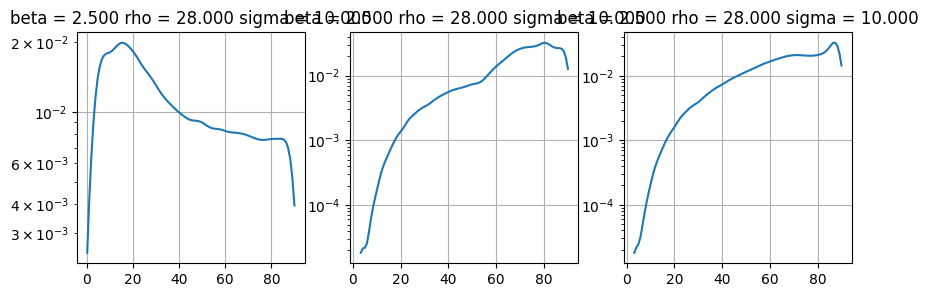

In [140]:
# for rho in [28.0,29.0,30.0,31.0,32.0,33.0]:
params = {'beta':2.5,'rho':28.0,'sigma':10.0}
LT = Lyapunov_Time(sys, params)
sim_time = 2000*LT + transient_time
my_sys, y_sim, t_sim = pp.load_data_dyn_sys(
    Lorenz63, params, sim_time, sim_dt, y_init=[-2.4, -3.7, 14.98], integrator=integrator
)
y_, t_ = pp.discard_transient(y_sim, t_sim, transient_time)
LEs, FTLE, QQ, RR= lyap.calculate_LEs(
    sys=my_sys,
    sys_type="continuous",
    X=y_,
    t=t_,
    transient_time=transient_time,
    dt=sim_dt,
    target_dim=None,
    norm_step=1,
)
V, theta, ftcle = lyap.calculate_CLVs(QQ, RR, sim_dt)
regime_str = ' '.join([f"{param} = {params[param]:0.3f}" for param in params.keys()])
plt.figure(figsize=(10,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    vis.plot_statistics(theta[:,i])
    plt.yscale('log')
    plt.title(regime_str)
        # plt.xlim([-1,10])
# plt.subplot(1,2,1)
# vis.plot_statistics(theta[:,0])
# plt.yscale('log')
# regime_str = ' '.join([f"{param} = {params[param]:0.3f}" for param in params.keys()])
# plt.title(regime_str)
# plt.xlabel('theta U,N')
# plt.ylabel('PDF')

# plt.subplot(1,2,2)
# vis.plot_statistics(theta[:,0])
# plt.yscale('log')
# plt.xlim([-1,10])
# plt.xlabel('theta U,N')
# plt.ylabel('PDF')

In [ ]:
sens_results = pp.unpickle_file(
        experiment_path / f"sensitivity_results_20240214_090024.pickle"
    )[0]
sens_results["dJdp"]["true"]["adjoint"]

In [141]:
sim_time = 5000*LT + transient_time
my_sys, y_sim, t_sim = pp.load_data_dyn_sys(
    Lorenz63, params, sim_time, sim_dt, y_init=[-2.4, -3.7, 14.98], integrator=integrator
)
y, t = pp.discard_transient(y_sim, t_sim, transient_time)

In [142]:
sens_results["beta_list"][15]

2.5000000000000013

In [ ]:
from matplotlib import cm
dJdbeta = sens_results["dJdp"]["true"]["adjoint"][15,0,:,0]
y_inits = np.zeros((len(dJdbeta),3))
loop_time = 0.5*LT
N_loop_sim = pp.get_steps(loop_time,sim_dt)
for loop_idx in range(len(dJdbeta)):
    y_inits[loop_idx] = y[loop_idx*N_loop_sim]

dJdbeta_idxs = dJdbeta < 10
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# plt.scatter(y_new[theta_idxs,0],y_new[theta_idxs,1], 
#             c='red', 
#             edgecolor='none',s=3)
plt.scatter(y_inits[dJdbeta_idxs,0],y_inits[dJdbeta_idxs,1],
            c=dJdbeta[dJdbeta_idxs], 
            cmap=cm.get_cmap('viridis'),
            edgecolor='none',s=2)
plt.colorbar()
plt.xlim([-15,15])
plt.ylim([-20,20])

plt.subplot(1,2,2)
# plt.scatter(y_new[theta_idxs,0],y_new[theta_idxs,2], 
#             c='red', 
#             edgecolor='none',s=3)
plt.scatter(y_inits[dJdbeta_idxs,0],y_inits[dJdbeta_idxs,2],
            c=dJdbeta[dJdbeta_idxs], 
            cmap=cm.get_cmap('viridis'),
            edgecolor='none',s=2)
plt.colorbar()
plt.xlim([-15,15])
plt.ylim([5,45])

y_new = y_[2001:,:]
which_theta = 2
theta_idxs = theta[:,which_theta] < 90
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(y_new[theta_idxs,0],y_new[theta_idxs,1], 
            c=theta[theta_idxs,which_theta], 
            cmap=cm.get_cmap('viridis'),
            edgecolor='none',s=1)
plt.colorbar()
plt.xlim([-15,15])
plt.ylim([-20,20])

plt.subplot(1,2,2)
plt.scatter(y_new[theta_idxs,0],y_new[theta_idxs,2], 
            c=theta[theta_idxs,which_theta], 
            cmap=cm.get_cmap('viridis'),
            edgecolor='none',s=1)
plt.colorbar()
plt.xlim([-15,15])
plt.ylim([5,45])

## Predict and visualize

beta = 2.000 rho = 52.000 sigma = 13.000
Mean PH: 4.8 Std PH: 0.0
Mean PH: 4.849999999999999 Std PH: 0.0




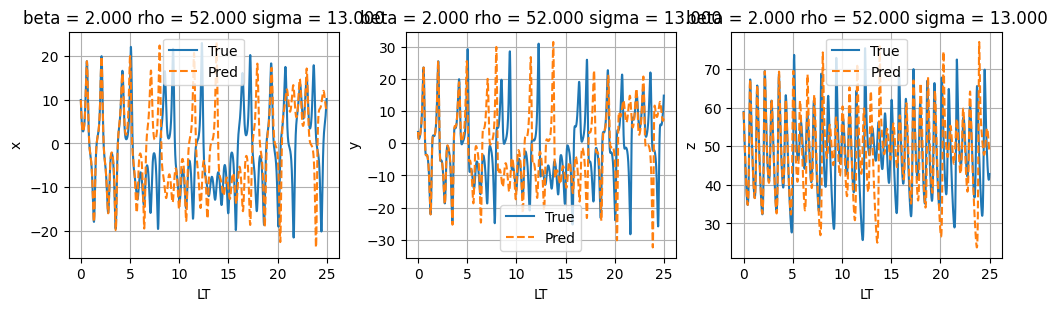

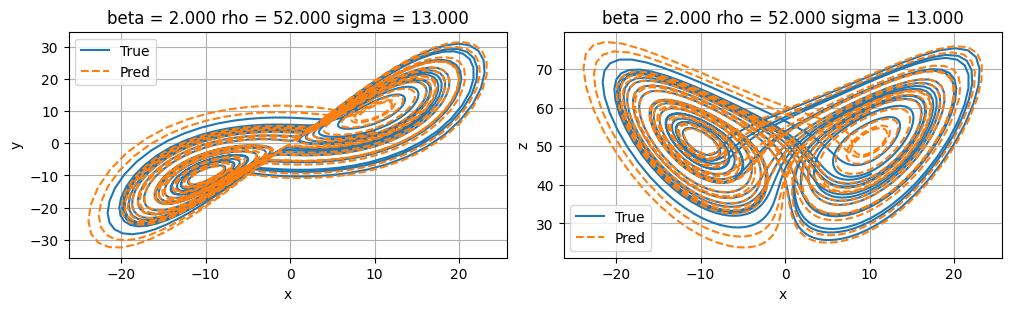

In [9]:
transient_time = 20
loop_times = [20] * 1
sim_time = np.sum(loop_times) + transient_time + len(loop_times)*washout_time

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = [2.0]
    param_mesh_input[eParam.rho] = [52.0]
    param_mesh_input[eParam.sigma] = [13.0]
    eVars = my_sys.get_eVar()
    plt_idx = [eVars.x,eVars.y,eVars.z]
    plt_idx_pairs = [[eVars.x, eVars.y],
                    [eVars.x,eVars.z],]
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = np.arange(5,10,1)
    eVars = my_sys.get_eVar()
    plt_idx = [eVars.x1, eVars.x2, eVars.x3]
    plt_idx_pairs = [[eVars.x1, eVars.x2],
                    [eVars.x1,eVars.x3],]

p_list = pp.make_param_mesh(param_mesh_input)

phase_space_steps = pp.get_steps(loop_times[0],network_dt)

error_measure = errors.rel_L2

for p_idx, p in enumerate(p_list):
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
    print(regime_str)
   
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                # random_seed=0,
                                                y_init=[-2.4,-3.7,14.98],
                                                integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times)
    
    # LT = Lyapunov_Time(sys, params)
    # print('Lyapunov time:', LT)
    LT = 0.8
    PH = np.zeros(len(loop_times))
    PH2 = np.zeros(len(loop_times))
    for loop_idx, loop_name in enumerate(data.keys()):
        param0 = np.array([data[loop_name]["p"][0,:]])
        p_washout_auto = np.repeat(param0, [len(DATA["train"]["u_washout"][0])], axis = 0)
        # x_open_loop = my_ESN.open_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
        #                                     U=data[loop_name]["u"], 
        #                                     P_washout=data[loop_name]["p_washout"],  
        #                                     P=data[loop_name]["p"])

        x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        
        # ol_rank = np.linalg.matrix_rank(np.matmul(x_open_loop.T,x_open_loop))
        # cl_rank = np.linalg.matrix_rank(np.matmul(x_pred.T,x_pred))
        # print('Open loop rank:', ol_rank, ', Closed loop rank:', cl_rank)

        # PREDICTABILITY
        PH[loop_idx] = predictability_horizon(data[loop_name]["y"], y_pred, data[loop_name]["t"]-data[loop_name]["t"][0], LT)
        PH2[loop_idx] = predictability_horizon2(data[loop_name]["y"], y_pred, data[loop_name]["t"]-data[loop_name]["t"][0], LT)
        # print("Predictability horizon:", PH[loop_idx])
        # plot time series
        plt.figure(figsize = (10,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            t = (data[loop_name]["t"]-data[loop_name]["t"][0])/LT
            vis.plot_lines(t,data[loop_name]["y"][:,k],
                           y_pred[:,k],
                        title=regime_str,
                        xlabel='LT',
                        ylabel=k.name,
                        linestyle=['-','--'],
                        legend=['True','Pred'])
            
        # plot phase space  
        plt.figure(figsize = (10,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx_pairs),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             xlabel=k[0].name,
                             ylabel=k[1].name,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])
            
        # fig = plt.figure(figsize = (10,5),constrained_layout=True)
        # vis.plot_lorenz63_attractor(fig, data[loop_name]["y"],y_pred,length=phase_space_steps)

        # plot statistics    
        # plt.figure(figsize = (15,3),constrained_layout=True)
        # for j, k in enumerate(plt_idx):
        #     plt.subplot(1,len(plt_idx),j+1)
        #     vis.plot_statistics(data[loop_name]["y"][:,k],
        #                         # y_pred[:,k],
        #                         title=regime_str,
        #                         ylabel='PDF',
        #                         linestyle=['-','--'],
        #                         legend=['True','Pred'])

    print('Mean PH:', np.mean(PH), 'Std PH:', np.std(PH))
    print('Mean PH:', np.mean(PH2), 'Std PH:', np.std(PH2))
    print('\n')

In [10]:
%timeit my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], N_t=len(data[loop_name]["u"]), P_washout=data[loop_name]["p_washout"],  P=data[loop_name]["p"])

270 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
len(data[loop_name]["u"])

2000

## Statistics

In [21]:
# generate and train ESN realisations
n_ensemble = 1
res_idx = 0
ESN_list = [None] * n_ensemble
for e_idx in range(n_ensemble):
    # fix the seeds
    input_seeds = [5,6,7]
    reservoir_seeds = [8,9]

    # expand the ESN dict with the fixed seeds
    ESN_dict["input_seeds"] = input_seeds
    ESN_dict["reservoir_seeds"] = reservoir_seeds
    ESN_dict["verbose"] = False
    my_ESN = ESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

    my_ESN.train(DATA["train"]["u_washout"], 
                DATA["train"]["u"], 
                DATA["train"]["y"],
                P_washout=DATA["train"]["p_washout"], 
                P_train=DATA["train"]["p"],
                train_idx_list=train_idx_list)
    ESN_list[e_idx] = my_ESN

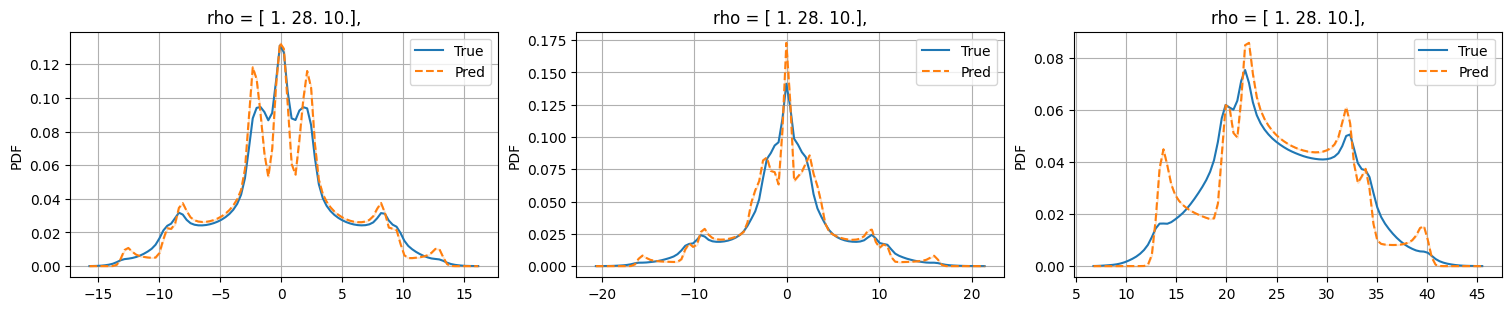

In [22]:
LT =  2.1
loop_times = [LT*5000]
sim_time = loop_times[0] + transient_time + 10

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = [1.0]
    param_mesh_input[eParam.rho] = [28.0]
    param_mesh_input[eParam.sigma] = [10.0]
    eVars = my_sys.get_eVar()
    plt_idx = [eVars.x, eVars.y, eVars.z]
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = [8.0]

p_list = pp.make_param_mesh(param_mesh_input)

for p_idx, p in enumerate(p_list):
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                y_init=[-2.4,-3.7,14.98],
                                                # random_seed=0,
                                                integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times)
    
    for loop_name in data.keys():
        Y_PRED = [None] * n_ensemble
        for e_idx, my_ESN in enumerate(ESN_list):
            param0 = np.array([data[loop_name]["p"][0,:]])
            p_washout_auto = np.repeat(param0, [len(DATA["train"]["u_washout"][0])], axis = 0)
            _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                        N_t=len(data[loop_name]["u"]), 
                                                        P_washout=data[loop_name]["p_washout"],  
                                                        P=data[loop_name]["p"])
            y_pred = y_pred[1:]
            Y_PRED[e_idx] = y_pred
            regime_str = f'rho = {p},'

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics_ensemble(*[Y_PRED[e][:, k] for e in range(n_ensemble)],
                                y_base=data[loop_name]["y"][:,k],
                                title=regime_str,
                                ylabel='PDF',
                                linestyle=['-','--'],
                                legend=['True','Pred'],
                                color=["tab:blue","tab:orange"])

## Objective

In [15]:
def objective_fun(u):
    return np.mean(u[:,2])

loop_times = [5000]
sim_time = loop_times[-1]

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = [2.0]
    param_mesh_input[eParam.rho] = [52.0]
    param_mesh_input[eParam.sigma] = np.arange(10,12,0.1)
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = np.arange(5,11,0.5)

p_list = pp.make_param_mesh(param_mesh_input)

obj_bar = np.zeros(len(p_list))
obj_bar_pred = np.zeros(len(p_list))

for p_idx, p in enumerate(p_list):
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    print(p)
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt=sim_dt,
                                                random_seed=0,
                                                # y_init=np.array([-2.4,-3.7,14.98]),
                                                integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        start_idxs=[0,0,0,0]
                        )

    obj_bar[p_idx] = objective_fun(data["loop_0"]["y"])
    # obj_bar[p_idx] = objective_fun(y_sim)
    
    # for loop_name in data.keys():
    #     _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
    #                                                 N_t=len(data[loop_name]["u"]), 
    #                                                 P_washout=data[loop_name]["p_washout"],  
    #                                                 P=data[loop_name]["p"])
    #     y_pred = y_pred[1:]

    # obj_bar_pred[p_idx] = objective_fun(y_pred)

[ 2. 52. 10.]
[ 2.  52.  10.1]
[ 2.  52.  10.2]
[ 2.  52.  10.3]
[ 2.  52.  10.4]
[ 2.  52.  10.5]
[ 2.  52.  10.6]
[ 2.  52.  10.7]
[ 2.  52.  10.8]
[ 2.  52.  10.9]
[ 2. 52. 11.]
[ 2.  52.  11.1]
[ 2.  52.  11.2]
[ 2.  52.  11.3]
[ 2.  52.  11.4]
[ 2.  52.  11.5]
[ 2.  52.  11.6]
[ 2.  52.  11.7]
[ 2.  52.  11.8]
[ 2.  52.  11.9]


In [143]:
timesteps = sim_dt * np.arange(1,len(y_sim)+1)
cum_z_bar = 1/np.arange(1,len(y_sim)+1) * np.cumsum(y_sim[:,2])
z_bar = np.mean(y_sim[:,2])

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(data["loop_0"]["t"],data["loop_0"]["y"][:,2])
plt.figure(figsize=(15,3))
plt.plot(data["loop_1"]["t"],data["loop_1"]["y"][:,2])
# plt.figure(figsize=(15,3))
# plt.plot(data["loop_2"]["t"],data["loop_2"]["y"][:,2])
# plt.plot(data["loop_0"]["t"],y_pred[:,2])

Mean by taking the mean of observations: 23.657235987659053
Mean by integrating the pdf: 23.65723598765895
Mean by taking the mean of observations: 23.549208326340974
Mean by integrating the pdf: 23.549208326340175
Mean by taking the mean of observations: 23.54406006671089
Mean by integrating the pdf: 23.544060066706344


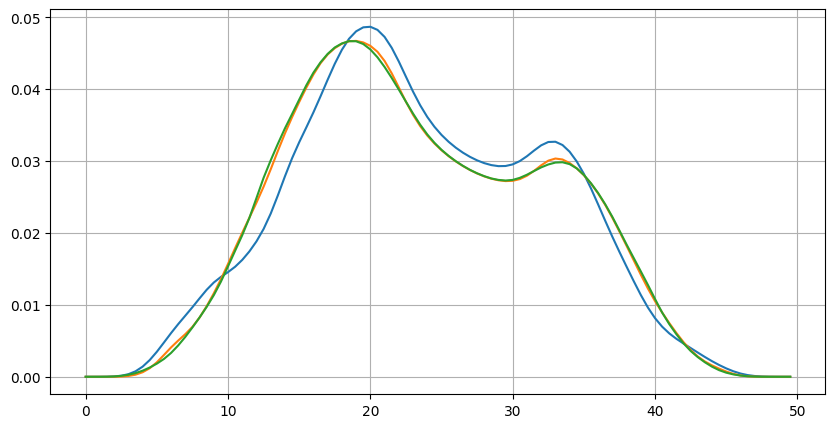

In [45]:
from scipy import signal, stats
from scipy.integrate import quad

n_bins = 100
binwidth = 0.1
bandwidth = 0.05
plt.figure(figsize=(10,5))
for loop_name in data.keys():
    yy = data[loop_name]["y"][:,2]
    density = stats.gaussian_kde(yy)
    # n, x = np.histogram(yy, bins = np.arange(min(yy), max(yy) + binwidth, binwidth), density=True)
    n, x = np.histogram(yy, bins = n_bins, density=True)
    bin_centers = 0.5*(x[1:]+x[:-1])

    mean_integration = quad(lambda x: x * density(x), a=-np.inf, b=np.inf)[0]
    variance_integration = quad(lambda x: (x ** 2) * density(x), a=-np.inf, b=np.inf)[0] - mean_integration ** 2

    print("Mean by taking the mean of observations:",np.mean(yy))
    print("Mean by integrating the pdf:",mean_integration)

    # plt.plot(bin_centers,n) ## using bin_centers rather than edges
    x = np.arange(0,50,0.5)
    plt.plot(x, density(x))
    plt.grid()
    # plt.xlim([0,10])

In [9]:
def plot_obj_and_grad(p_list, obj_bar, obj_bar_pred, eParam_name, degree = 2, idxs=None, plot=True):
    if idxs is not None:
        p_list = p_list[idxs,:]
        obj_bar = obj_bar[idxs]
        obj_bar_pred = obj_bar_pred[idxs]
    results = np.polyfit(p_list[:,eParam_name],obj_bar, deg = degree, full=True)
    coeffs = results[0]
    print(coeffs)
    residual = results[1]

    var = 1/(len(p_list)-2) * residual
    denom = np.sum((p_list[:,eParam_name]-np.mean(p_list[:,eParam_name]))**2)
    var_coeff = var/denom
    std_coeff = np.sqrt(var_coeff)
    # print(std_coeff)
    # nom = np.sum((p_list[:,eParam_name]-np.mean(p_list[:,eParam_name]))*obj_bar)
    # coeffs2 = nom/denom
    # print(coeffs2)

    vals = np.polyval(coeffs, p_list[:,eParam_name])
    coeffs_pred = np.polyfit(p_list[:,eParam_name],obj_bar_pred, deg = degree)
    vals_pred = np.polyval(coeffs_pred, p_list[:,eParam_name])
    if plot == True:
        plt.figure(figsize=(15,5))

        plt.subplot(1,2,1)
        plt.plot(p_list[:,eParam_name],obj_bar,'-',linewidth=2)
        # plt.plot(p_list[:,eParam_name],obj_bar_pred, '--+', color="tab:orange",linewidth=2)
        # plt.xlabel(eParam_name.name)
        # plt.ylabel("z_bar")
        # plt.legend(["True","ESN"])
        # plt.grid()

        # plt.subplot(1,3,2)
        plt.plot(p_list[:,eParam_name],vals,'--',linewidth=2)
        # plt.plot(p_list[:,eParam_name],vals_pred, '--+', color="tab:orange")
        # plt.xlabel(eParam_name.name)
        # plt.ylabel("z_bar")
        plt.legend(["True","Approx"])
        plt.title(f"Degree {degree} polynomial approx")
        plt.grid()

        # plt.subplot(1,2,2)
        # spacing = p_list[:,eParam_name][1]-p_list[:,eParam_name][0]
        # grads = np.gradient(vals,spacing)
        # grads_pred = np.gradient(vals_pred,spacing)
        # plt.plot(p_list[:,eParam_name],grads,'-',linewidth=2)
        # # plt.plot(p_list[:,eParam_name],grads_pred, '--+', color="tab:orange")
        # plt.xlabel(eParam_name.name)
        # plt.ylabel(f"dz_bar/d{eParam_name.name}")
        # plt.legend(["True","ESN"])
        # plt.grid()

[-5.53977374e-01  3.03265616e+01 -6.63386324e+02  7.24805900e+03
 -3.95529146e+04  8.62902668e+04]


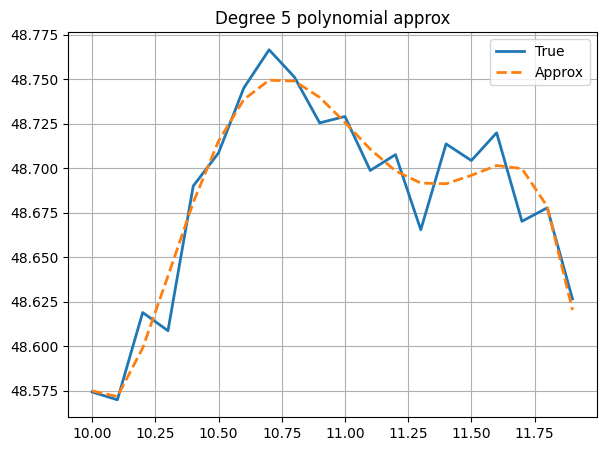

In [18]:
idxs = np.where((p_list[:,eParam.rho] >= 25) & (p_list[:,eParam.rho] <= 100))[0]
plot_obj_and_grad(p_list, obj_bar, obj_bar, eParam.sigma, degree = 5, idxs=idxs)

[-1.52501652 26.71309733]


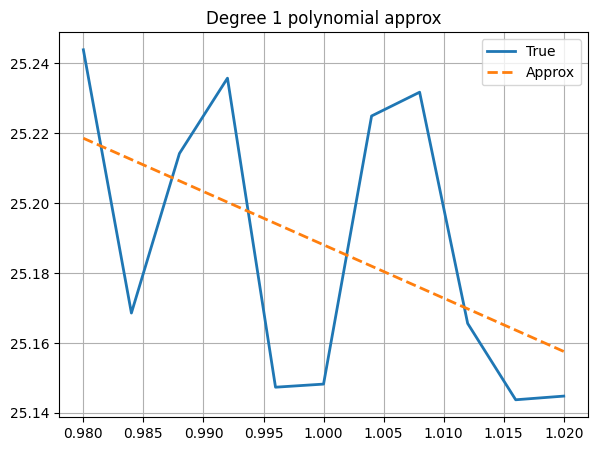

In [15]:
idxs = np.where((p_list[:,eParam.rho] >= 25) & (p_list[:,eParam.rho] <= 100))[0]
plot_obj_and_grad(p_list, obj_bar, obj_bar, eParam.beta, degree = 1, idxs=idxs)

[ 1.26622199 23.94054443]


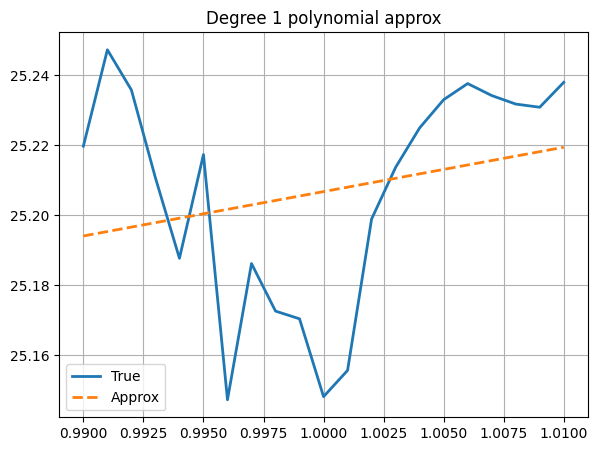

In [18]:
idxs = np.where((p_list[:,eParam.rho] >= 25) & (p_list[:,eParam.rho] <= 100))[0]
plot_obj_and_grad(p_list, obj_bar, obj_bar, eParam.beta, degree = 1, idxs=idxs)

In [13]:
obj_results = pp.unpickle_file("../local_results/lorenz63/objective_results_20240201_191334.pickle")[0]

(78.0, 85.0)

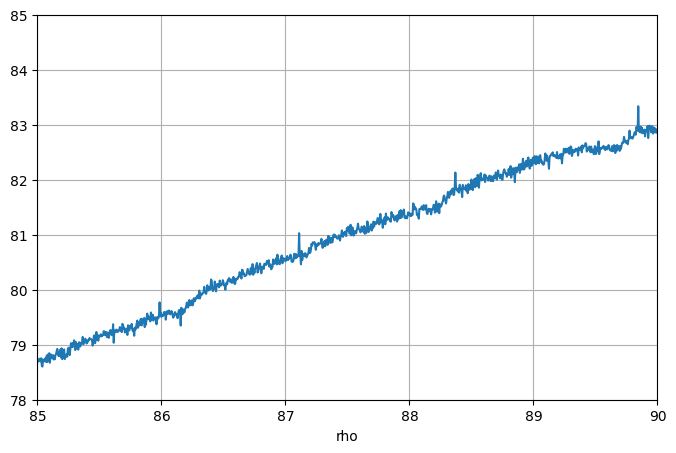

In [84]:
# for i in np.arange(len(obj_results["loop_times"])-1):
#     plt.subplot(2,2,i+1)
#     plt.plot(obj_results["rho_list"],obj_results["J"][:,i])
#     plt.xlabel("rho")
#     plt.ylim([0,100])
#     plt.grid()

plt.figure(figsize=(8,5))
# plt.plot(obj_results["rho_list"],obj_results["J"][:,3],'--')
plt.plot(obj_results["rho_list"],obj_results["J"][:,4])

plt.xlabel("rho")
# plt.ylim([0,100])
plt.grid()
plt.xlim([25,30])
plt.ylim([20,27])

plt.xlim([85,90])
plt.ylim([78,85])

In [39]:
param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = obj_results["beta_list"]
param_mesh_input[eParam.rho] = obj_results["rho_list"]
param_mesh_input[eParam.sigma] = obj_results["sigma_list"]
p_list = pp.make_param_mesh(param_mesh_input)
for my_rho in np.arange(26,50,1):
        idxs = np.where((p_list[:,eParam.rho] >= my_rho-0.2) & (p_list[:,eParam.rho] <= my_rho+0.2))[0]
        grads = plot_obj_and_grad(p_list, obj_results["J"][:,4], obj_results["J"][:,4], eParam.rho, degree = 1, idxs=idxs, plot=False)

[ 0.93256164 -2.68474607]
[ 0.9939169  -4.29161643]
[ 1.00257432 -4.53182565]
[ 0.9966592  -4.35430502]
[ 0.97404739 -3.66199035]
[ 1.03857183 -5.62439301]
[ 0.99533139 -4.2727452 ]
[ 1.02614072 -5.27890965]
[ 0.98333899 -3.84252462]
[ 0.9596247  -2.99581273]
[ 1.00992832 -4.75987065]
[ 1.01589842 -5.00293778]
[ 0.9911345  -4.08341392]
[ 0.97342316 -3.39779217]
[ 0.96042381 -2.86806769]
[ 0.99447456 -4.23793284]
[ 0.97949138 -3.63142218]
[ 0.93693977 -1.8072361 ]
[ 0.95413745 -2.52990888]
[ 0.93740413 -1.75556056]
[ 0.96635395 -3.06372423]
[ 0.97928562 -3.66627285]
[ 0.99272836 -4.32549092]
[ 0.96457307 -2.98656976]


[-1.13648645e-03  1.07516721e+00 -5.65495977e+00]


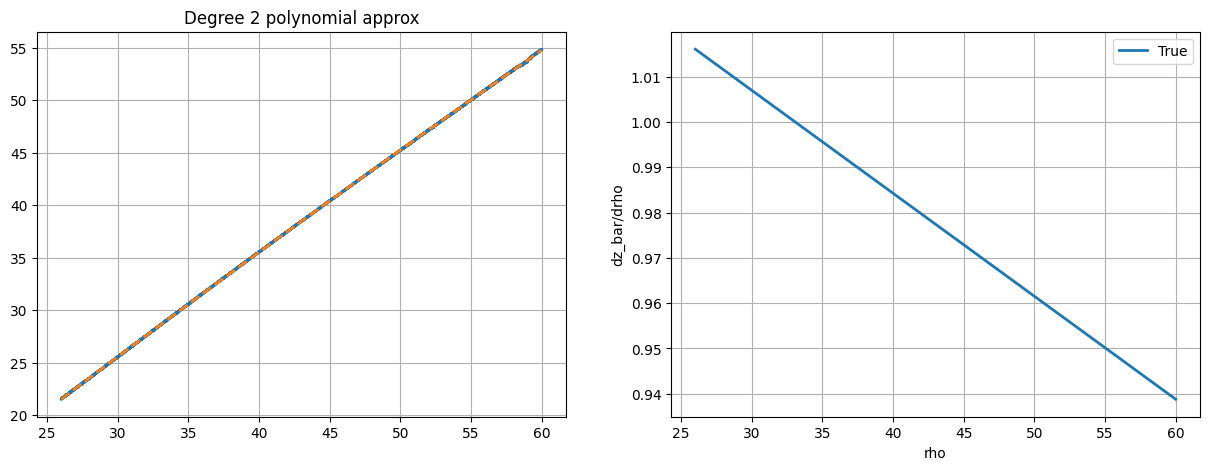

In [36]:
idxs = np.where((p_list[:,eParam.rho] >= 26.0) & (p_list[:,eParam.rho] <= 60.0))[0]
grads = plot_obj_and_grad(p_list, obj_results["J"][:,4], obj_results["J"][:,4], eParam.rho, degree = 2, idxs=idxs)

## Lyapunov stability analysis

In [25]:
params = {"beta": 2.0,
          "rho": 52.0,
          "sigma": 13.0}

sim_time = 524
loop_times = [500]
loop_names = ["test"]
my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,
                                            params,
                                            sim_time,
                                            sim_dt,
                                            random_seed=0,
                                            integrator=integrator)

data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=["x","y","z"],
                    param_vars=["beta","rho","sigma"],
                    loop_times=loop_times,
                    loop_names=loop_names)

LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_sys,
                                 sys_type='continuous',
                                 X=data["test"]["u"],
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=network_dt,
                                 target_dim=None,
                                 norm_step=1)
LEs_target = LEs[-1]
print('Lyapunov exponents:', LEs_target)
print('Lyapunov time:', 1/LEs_target[0])
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,network_dt)

Lyapunov exponents: [ 1.24409727e+00  8.95092254e-04 -1.72447241e+01]
Lyapunov time: 0.8037956738832969


In [26]:
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["test"]["u_washout"], 
                                                        N_t=len(data["test"]["u"]), 
                                                        P_washout=data["test"]["p_washout"],  
                                                        P=data["test"]["p"])
y_pred = y_pred[1:]
LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
                                 sys_type='ESN',
                                 X=x_pred,
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=network_dt,
                                 target_dim=my_sys.N_dim,
                                 norm_step=1,
                                 fast_jac=True)
LEs_target_esn = LEs[-1]
print('Lyapunov exponents:', LEs_target_esn)
print('Lyapunov time:', 1/LEs_target_esn[0])
CLVs_esn, angles_esn, FTCLE_esn = lyap.calculate_CLVs(QQ,RR,network_dt)

Lyapunov exponents: [ 1.25219008e+00 -2.00105553e-03 -1.72947097e+01]
Lyapunov time: 0.7986008000223818


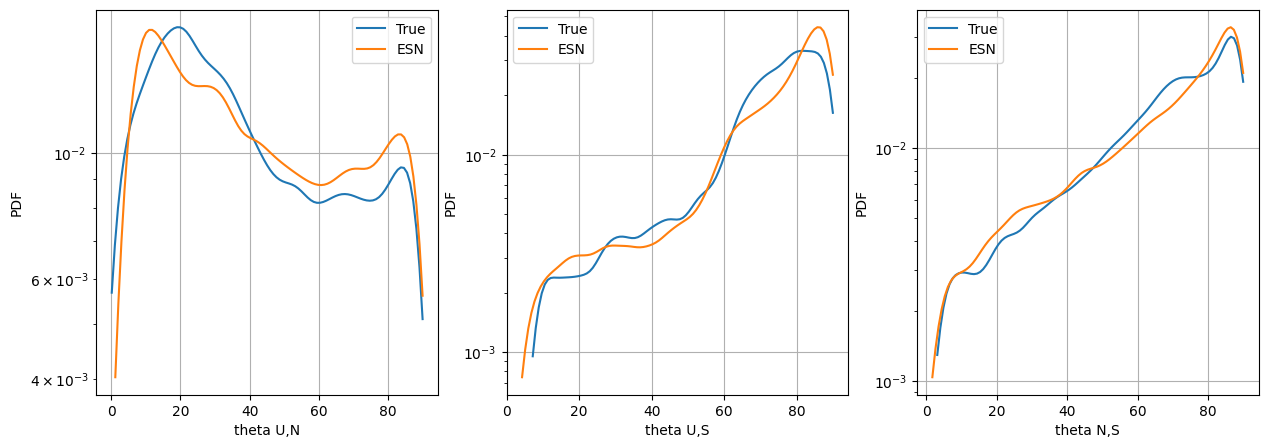

In [27]:
plt.figure(figsize=(15,5))
angle_names = ["U,N", "U,S", "N,S"]
for i in range(3):
    plt.subplot(1,3,i+1)
    vis.plot_statistics(angles[:,i], angles_esn[:,i])
    plt.yscale('log')
    plt.xlabel(f'theta {angle_names[i]}')
    plt.ylabel("PDF")
    plt.legend(["True","ESN"])

## Sensitivity

In [23]:
from adjoint_esn.utils import dynamical_systems_sensitivity as sens

def objective_fun(u):
    return np.mean(u[:,2])

def dobjective_fun(u):
    dobj = np.zeros(len(u))
    dobj[2] = 1
    return dobj

# def objective_fun(u):
#     return np.mean(np.sum(u, axis=1))

# def dobjective_fun(u):
#     return np.array([1,1,1])

# def objective_fun(u):
#     return np.mean(np.sum(u**2, axis=1))

# def dobjective_fun(u):
#     return 2*u


In [9]:
if sys == Lorenz63:
    params = {}
    params["beta"] = 8/3
    params["rho"] = 28.0
    params["sigma"] = 10.0
elif sys == Lorenz96:
    params = {}
    params["p"] = 8.0

sim_time = 1.0
for random_seed in range(1):
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                random_seed=random_seed,
                                                integrator=integrator)

    dJdp_direct = sens.true_direct_sensitivity(my_sys, t_sim, y_sim, dobjective_fun,integrator=integrator)
    dJdp_adj = sens.true_adjoint_sensitivity(my_sys, t_sim, y_sim, dobjective_fun,integrator=integrator)
    dJdp_finite = sens.true_finite_difference_sensitivity(
        my_sys, t_sim, y_sim, h=1e-8, objective_fun=objective_fun, method="central",integrator=integrator)
    print('Direct', dJdp_direct)
    print('Adjoint', dJdp_adj)
    print('Finite', dJdp_finite)

Direct [-0.98474768  1.0932801   0.10018773]
Adjoint [-0.98474768  1.0932801   0.10018773]
Finite [-0.95895896  1.09470086  0.09954153]


In [24]:
n_loops = 1
loop_times = [100]
loop_time_arr = np.arange(0.1,3.1,0.1)
transient_time = 20.0
washout_time = 4.0
sim_time = loop_times[-1] + transient_time + 10

if sys == Lorenz63:
    param_mesh_input = [None] * 3
    param_mesh_input[eParam.beta] = [8/3]
    param_mesh_input[eParam.rho] = [28.0]
    param_mesh_input[eParam.sigma] = [10.0]
elif sys == Lorenz96:
    param_mesh_input = [None] * 1
    param_mesh_input[eParam.p] = [8.0]

p_list = pp.make_param_mesh(param_mesh_input)

# y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
# y0[0,:] = data["loop_0"]["u_washout"][-1]
# u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

methods = ['direct','adjoint','finite']
dJdp = {'true':{},'esn':{}}
for method_name in methods:
    dJdp['true'][method_name] = np.zeros((len(p_list),my_sys.N_param,n_loops,len(loop_time_arr)))
    dJdp['esn'][method_name] = np.zeros((len(p_list),len(param_vars),n_loops,len(loop_time_arr)))

hh = 1e-5
for p_idx, p in enumerate(p_list):
    params = {}
    for param in eParam:
        params[param.name] = p[param]
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
    print(regime_str)

    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                # random_seed=3,
                                                y_init=np.array([-2.4,-3.7,14.98]),
                                                integrator=integrator)

    hi_data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=sim_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        )
    
    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        )
    
    # predict on the whole timeseries
    N = len(data["loop_0"]["u"])
    param0 = np.array([data["loop_0"]["p"][0,:]])
    p_washout_auto = np.repeat(param0, [len(DATA["train"]["u_washout"][0])], axis = 0)
    x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["loop_0"]["u_washout"], 
                                                    N_t=N, 
                                                    P_washout=data["loop_0"]["p_washout"],  
                                                    P=data["loop_0"]["p"])
    for loop_time_idx, loop_time in enumerate(loop_time_arr):
        print("Loop time:", loop_time)
        N_loop_sim = pp.get_steps(loop_time,sim_dt)
        N_loop_network = pp.get_steps(loop_time,network_dt)

        for loop_idx in range(n_loops): 
            print(f"Loop {loop_idx}")
            # split the simulation data
            t_bar = hi_data["loop_0"]["t"][loop_idx*N_loop_sim:(loop_idx+1)*N_loop_sim+1]
            t_bar = t_bar-t_bar[0]
            y_bar = hi_data["loop_0"]["u"][loop_idx*N_loop_sim:(loop_idx+1)*N_loop_sim+1]

            # dJdp["true"]["direct"][p_idx,:,loop_idx,loop_time_idx] = sens.true_direct_sensitivity(my_sys, t_bar, y_bar, dobjective_fun,integrator=integrator)
            dJdp["true"]["adjoint"][p_idx,:,loop_idx,loop_time_idx] = sens.true_adjoint_sensitivity(my_sys, t_bar, y_bar, dobjective_fun,
                                                                                                    integrator=integrator)
            dJdp["true"]["finite"][p_idx,:,loop_idx,loop_time_idx] = sens.true_finite_difference_sensitivity(
                my_sys, t_bar, y_bar, h=hh, objective_fun=objective_fun, method="central",integrator=integrator)


            # # split the prediction data
            t_loop = data["loop_0"]["t"][loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]
            t_loop = t_loop-t_loop[0]
            x_pred_loop = x_pred[loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]
            y_pred_loop = y_pred[loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]
            p_loop = data["loop_0"]["p"][loop_idx*N_loop_network:(loop_idx+1)*N_loop_network+1]

            # # dJdp["esn"]["direct"][p_idx,:,loop_idx,loop_time_idx] = my_ESN.direct_sensitivity(x_pred_loop, y_pred_loop, N_loop_network, dJdy_fun=dobjective_fun)
            dJdp["esn"]["adjoint"][p_idx,:,loop_idx,loop_time_idx] = my_ESN.adjoint_sensitivity(x_pred_loop, y_pred_loop, N_loop_network, dJdy_fun=dobjective_fun)                    
            dJdp["esn"]["finite"][p_idx,:,loop_idx,loop_time_idx] = my_ESN.finite_difference_sensitivity(X=x_pred_loop, 
                                                                Y=y_pred_loop,  
                                                                P=p_loop, 
                                                                N=N_loop_network, 
                                                                h=hh,
                                                                method="central",
                                                                J_fun=objective_fun)
            
            print('J: ', objective_fun(y_bar[1:]))
            # print('J esn: ', objective_fun(y_pred_loop[1:]))

            # print('Direct:', dJdp["true"]["direct"][p_idx,:,loop_idx,loop_time_idx])
            # print('Direct esn:', dJdp["esn"]["direct"][p_idx,:,loop_idx,loop_time_idx])

            print('Adjoint:', dJdp["true"]["adjoint"][p_idx,:,loop_idx,loop_time_idx])
            print('Adjoint esn:', dJdp["esn"]["adjoint"][p_idx,:,loop_idx,loop_time_idx])

            print('Finite:', dJdp["true"]["finite"][p_idx,:,loop_idx,loop_time_idx])
            print('Finite esn:', dJdp["esn"]["finite"][p_idx,:,loop_idx,loop_time_idx])

            # plt.figure()
            # plt.plot(t_bar, y_bar)
            # plt.plot(t_loop, y_pred_loop,'--')        

beta = 2.667 rho = 28.000 sigma = 10.000
Loop time: 0.1
Loop 0
J:  33.382216540011434
Adjoint: [-1.28776721  0.25516546  0.00596183]
Adjoint esn: [-1.58414305  0.29513227 -0.00762918]
Finite: [-1.39682377  0.29057587  0.00550622]
Finite esn: [-1.58414303  0.29513229 -0.00762918]
Loop time: 0.2
Loop 0
J:  32.93422771118965
Adjoint: [-1.85398323  0.64078545 -0.01260543]
Adjoint esn: [-1.96434235  0.67697362 -0.02404693]
Finite: [-1.9152686   0.67137158 -0.01345042]
Finite esn: [-1.96434232  0.67697363 -0.02404694]
Loop time: 0.30000000000000004
Loop 0
J:  30.774681900432338
Adjoint: [-2.05381423  0.8349579  -0.017366  ]
Adjoint esn: [-2.06820278  0.85972286 -0.02493474]
Finite: [-2.09205138  0.85504245 -0.01771104]
Finite esn: [-2.06820276  0.85972286 -0.02493474]
Loop time: 0.4
Loop 0
J:  28.382777298969074
Adjoint: [-1.9824785   0.92526604 -0.01993176]
Adjoint esn: [-1.93346208  0.94362833 -0.02448405]
Finite: [-1.9925803   0.94034393 -0.02023315]
Finite esn: [-1.93346206  0.94362832 -

(0.0, 2.0)

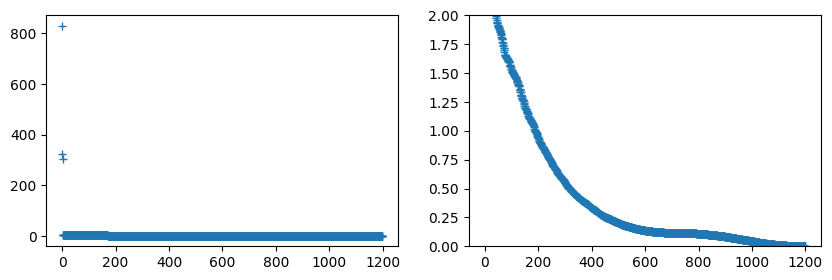

In [98]:
svals = np.zeros((len(x_pred)-1,1200))
# for i in np.arange(0,len(x_pred)-1,100):
i = 0
dtanh = my_ESN.dtanh(x_pred[i+1],x_pred[i])[:,None]
jac = my_ESN.jac(dtanh,x_pred[i])
svals = np.linalg.svd(jac, compute_uv=False)

# evals = np.linalg.eigvals(jac)
# plt.plot(np.abs(evals),'+')

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(svals,'+')
plt.subplot(1,2,2)
plt.plot(svals,'+')
plt.ylim([0,2])

In [7]:
def true_dfdp(y_bar,y_bar_next):
    h = 1e-3
    dydp = np.zeros((3,3))
    for param_idx in range(my_sys.N_param):
        param_name = eParam(param_idx).name
        current_param = getattr(my_sys, param_name)

        # perturb from the right
        setattr(my_sys, param_name, current_param + h)
        y_bar_right = solve_ode.integrate(
            my_sys.ode, y_bar, [0.0,sim_dt], integrator=integrator
        )
        # set the current parameter back
        setattr(my_sys, param_name, current_param)
        dydp[:,param_idx] = (y_bar_right[1]-y_bar_next)/h
    return dydp

dfdp_esn = np.zeros((len(x_pred_loop)-1,3,3))
dfdp_true = np.zeros((len(x_pred_loop)-1,3,3))
for i in range(len(x_pred_loop)-1):
    dtanh = my_ESN.dtanh(x_pred_loop[i+1], x_pred_loop[i])[:,None]
    dfdp_esn[i] = np.matmul(my_ESN.W_out[:my_ESN.N_reservoir,:].T,my_ESN.dfdp(dtanh))
    dfdp_true[i] = true_dfdp(y_bar[i],y_bar[i+1])

In [116]:
eigvals_true = np.sort(np.linalg.eigvals(dfdp_true),axis=1)
eigvals_esn = np.sort(np.linalg.eigvals(dfdp_esn),axis=1)

In [117]:
eigvals_true[0]

array([-0.12483101+0.j, -0.07244795+0.j,  0.07430469+0.j])

In [118]:
eigvals_esn[0]

array([-0.14632771,  0.0116897 ,  0.48982107])

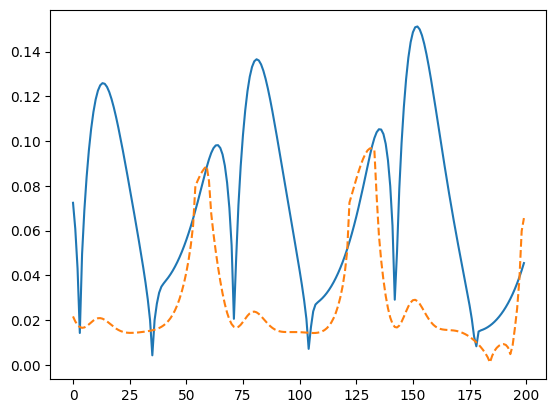

In [106]:
plt.plot(np.abs(eigvals_true)[:,1])
plt.plot(np.abs(eigvals_esn)[:,1],'--')

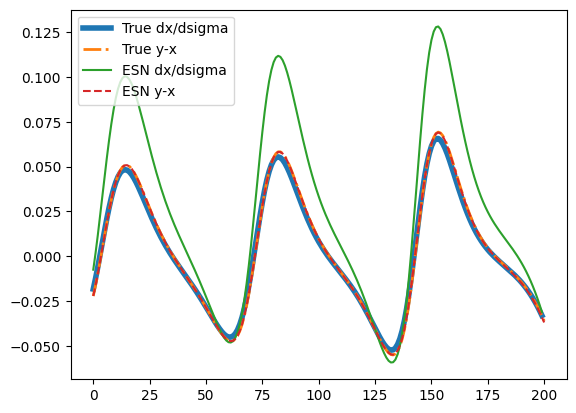

In [8]:
plt.plot(dfdp_true[:,0,2],linewidth=4)
# plt.plot(-sim_dt*(y_bar[:,2]),'--')
# plt.plot(sim_dt*(y_bar[:,0]),'--')
plt.plot(sim_dt*(y_bar[:,1]-y_bar[:,0]),'-.',linewidth=2)

plt.plot(dfdp_esn[:,0,2])
# plt.plot(-sim_dt*(y_pred_loop[:,2]),'--')
# plt.plot(sim_dt*(y_pred_loop[:,0]),'--')
plt.plot(sim_dt*(y_pred_loop[:,1]-y_pred_loop[:,0]),'--')
plt.legend(['True dx/dsigma','True y-x','ESN dx/dsigma','ESN y-x'])

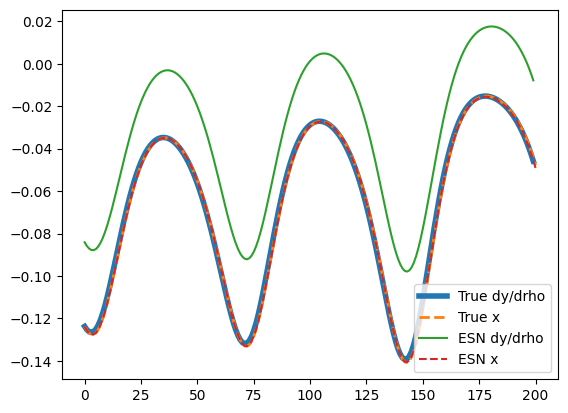

In [9]:
plt.plot(dfdp_true[:,1,1],linewidth=4)
# plt.plot(-sim_dt*(y_bar[:,2]),'--')
plt.plot(sim_dt*(y_bar[:,0]),'--',linewidth=2)
# plt.plot(sim_dt*(y_bar[:,1]-y_bar[:,0]),'-.',linewidth=2)

plt.plot(dfdp_esn[:,1,1])
# plt.plot(-sim_dt*(y_pred_loop[:,2]),'--')
plt.plot(sim_dt*(y_pred_loop[:,0]),'--')
# plt.plot(sim_dt*(y_pred_loop[:,1]-y_pred_loop[:,0]),'--')
plt.legend(['True dy/drho','True x','ESN dy/drho','ESN x'])

In [76]:
plt.plot(dfdp_true[:,2,0],linewidth=4)
plt.plot(-sim_dt*(y_bar[:,2]),'--',linewidth=2)
# plt.plot(sim_dt*(y_bar[:,0]),'--',linewidth=2)
# plt.plot(sim_dt*(y_bar[:,1]-y_bar[:,0]),'-.',linewidth=2)

plt.plot(dfdp_esn[:,2,0])
plt.plot(-sim_dt*(y_pred_loop[:,2]),'--')
# plt.plot(sim_dt*(y_pred_loop[:,0]),'--')
# plt.plot(sim_dt*(y_pred_loop[:,1]-y_pred_loop[:,0]),'--')
plt.legend(['True dz/dbeta','True -z','ESN dz/dbeta','ESN -z'])

NameError: name 'dfdp_true' is not defined

In [109]:
dydp = np.zeros((3,3))
for param_idx in range(my_sys.N_param):
    X_prev = x_pred[0]
    Y_prev = y_pred[0]
    P = p_loop[0].copy()
    P[param_idx] += 1e-3
    X = my_ESN.step(X_prev, Y_prev, P)
    Y = np.dot(X, my_ESN.W_out)
    dydp[:,param_idx] = (Y-y_pred[1])/1e-3

In [ ]:
sorted_idx = np.argsort(np.linalg.norm(dJdp["true"]["adjoint"][0,:,:,0],axis=0))
plt.plot(1/np.arange(1,101)*np.cumsum(dJdp["true"]["adjoint"][0,1,sorted_idx,0],axis=0))

sorted_idx = np.argsort(np.linalg.norm(dJdp["esn"]["adjoint"][0,:,:,0],axis=0))
plt.plot(1/np.arange(1,101)*np.cumsum(dJdp["esn"]["adjoint"][0,1,sorted_idx,0],axis=0))

plt.hlines(1.01,0,100,color='black',linestyle='--')

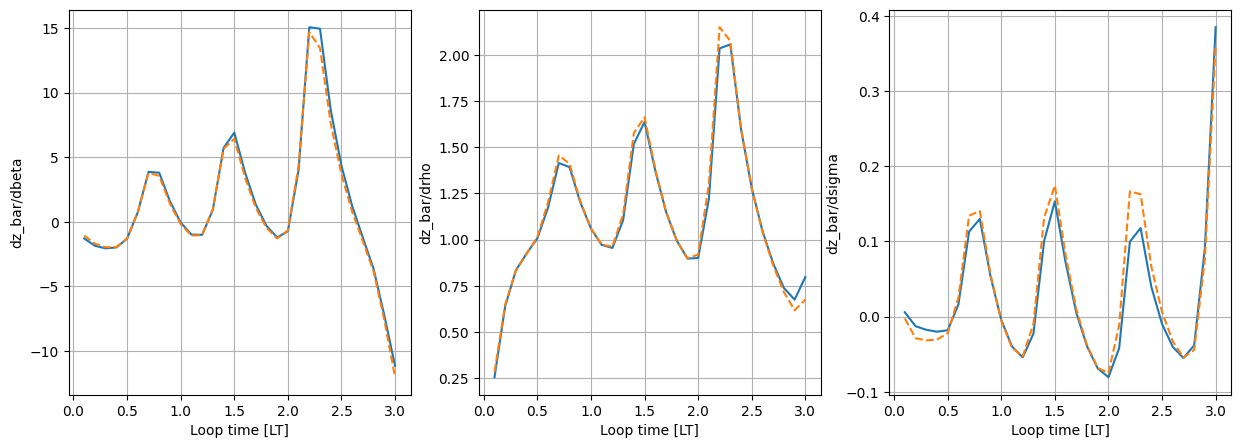

In [14]:
LT = 1.1
for loop_idx in range(n_loops):
    fig1 = plt.figure(figsize=(15,5))
    for i, param in enumerate(param_vars):
        plt.subplot(1,len(param_vars),i+1)
        plt.plot(loop_time_arr, dJdp["true"]["adjoint"][0,eParam[param],loop_idx,:])
        plt.plot(loop_time_arr, dJdp["esn"]["adjoint"][0,eParam[param],loop_idx,:],'--')
        plt.grid()
        plt.xlabel('Loop time [LT]')
        plt.ylabel(f"dz_bar/d{param}")

        # plt.xlim([0,4])
        # plt.ylim([-5,5])

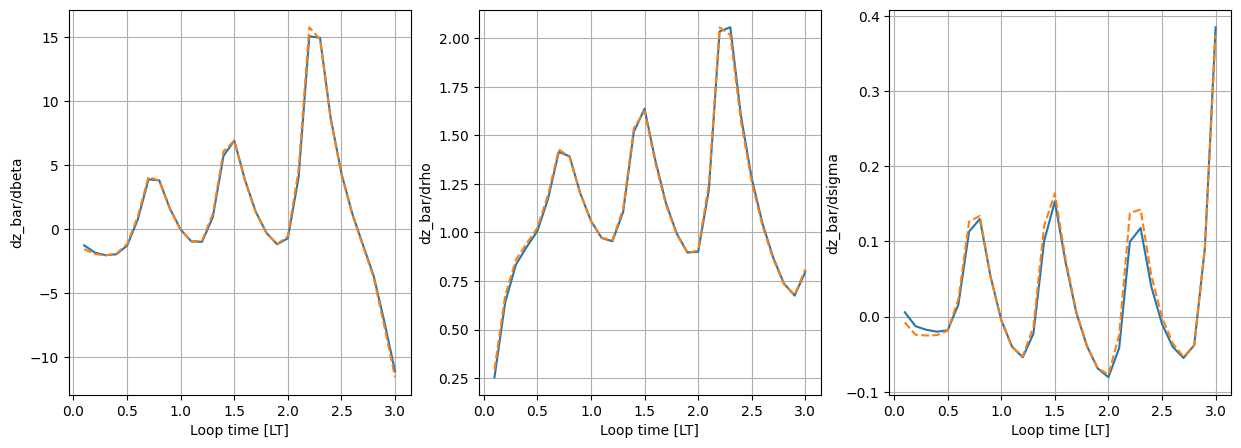

In [25]:
LT = 1.1
for loop_idx in range(n_loops):
    fig1 = plt.figure(figsize=(15,5))
    for i, param in enumerate(param_vars):
        plt.subplot(1,len(param_vars),i+1)
        plt.plot(loop_time_arr, dJdp["true"]["adjoint"][0,eParam[param],loop_idx,:])
        plt.plot(loop_time_arr, dJdp["esn"]["adjoint"][0,eParam[param],loop_idx,:],'--')
        plt.grid()
        plt.xlabel('Loop time [LT]')
        plt.ylabel(f"dz_bar/d{param}")

J: 23.72747561766727
J esn: 24.775009042137462
J left: 23.575799676977656
J left esn: 25.407115269957153
J right: 23.18186219959596
J right esn: 23.673448592896648
J: 23.72747561766727
J esn: 24.775009042137462
J left: 23.2695515957151
J left esn: 24.373813907588445
J right: 24.178574073248082
J right esn: 25.157511066876477
J: 23.72747561766727
J esn: 24.775009042137462
J left: 23.660110415744235
J left esn: 24.77785686200268
J right: 23.776976596551822
J right esn: 24.762345253209148


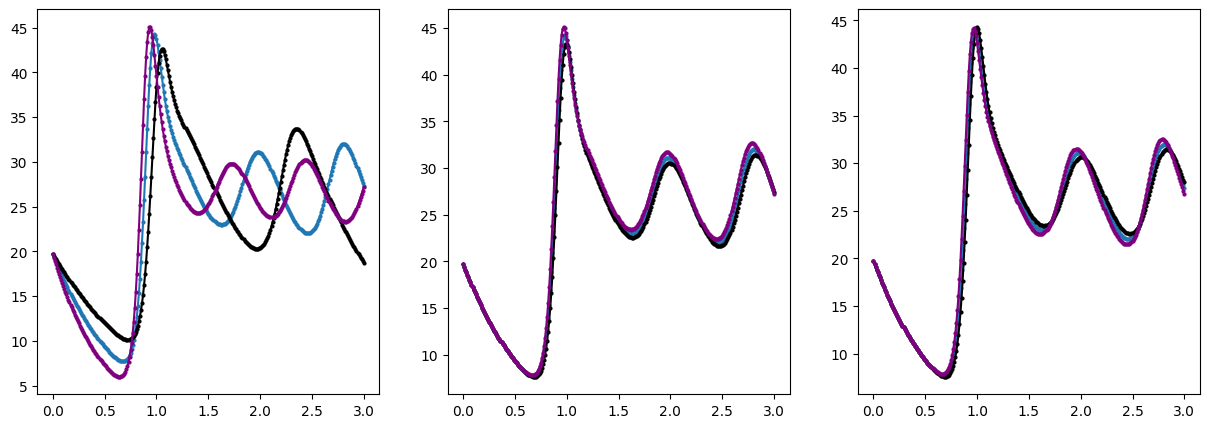

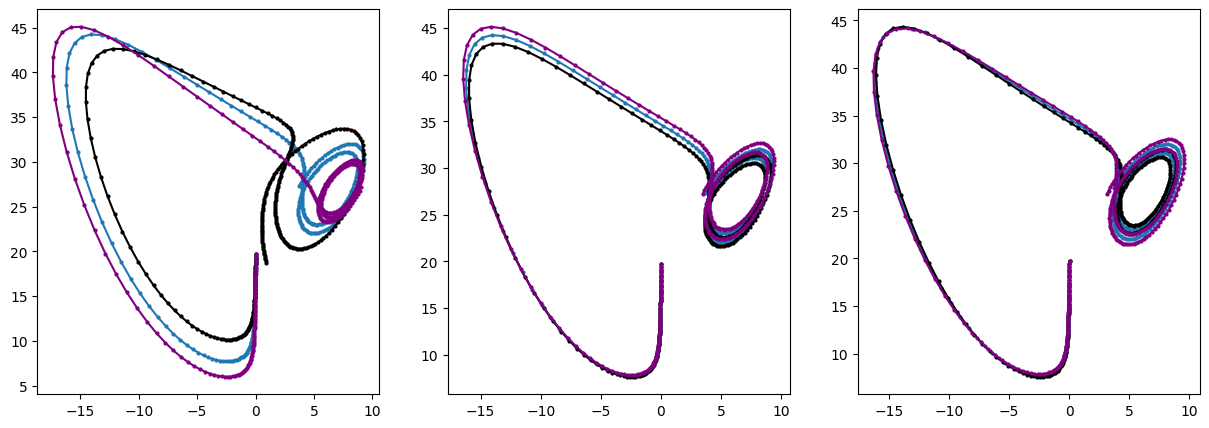

In [138]:
fig1 = plt.figure(figsize=(15,5))
fig2 = plt.figure(figsize=(15,5))
h = 5e-1

J = objective_fun(y_bar)
J_esn = objective_fun(y_pred_loop)

for param_idx in range(my_sys.N_param):
    param_name = eParam(param_idx).name
    current_param = getattr(my_sys, param_name)

    # perturb from the left
    setattr(my_sys, param_name, current_param - h)
    y_bar_left = solve_ode.integrate(
        my_sys.ode, y_bar[0], t_bar, integrator=integrator
    )
    
    # perturb from the right
    setattr(my_sys, param_name, current_param + h)
    y_bar_right = solve_ode.integrate(
        my_sys.ode, y_bar[0], t_bar, integrator=integrator
    )
    # set the current parameter back
    setattr(my_sys, param_name, current_param)
    

    # perturbed by h
    P_left = p_loop.copy()
    P_left[:, param_idx] -= h
    P_right = p_loop.copy()
    P_right[:, param_idx] += h
    _, Y_left = my_ESN.closed_loop(x_pred_loop[0, :], N_loop_network, P_left)
    _, Y_right = my_ESN.closed_loop(x_pred_loop[0, :], N_loop_network, P_right)

    J_left = objective_fun(y_bar_left)
    J_esn_left = objective_fun(Y_left)
    J_right = objective_fun(y_bar_right)
    J_esn_right = objective_fun(Y_right)
    # print(y_bar[0])
    # print(y_bar_left[0])
    # print(y_bar_right[0])
    # print(y_pred_loop[0])
    # print(Y_left[0])
    # print(Y_right[0])

    print("J:", J)
    print("J esn:", J_esn)
    print("J left:", J_left)
    print("J left esn:", J_esn_left)
    print("J right:", J_right)
    print("J right esn:" , J_esn_right)  

    ax1 = fig1.add_subplot(1,3,param_idx+1)
    idx = 2
    ax1.plot(t_bar, y_bar[:,idx], color="tab:blue",marker='o',markersize=2)
    ax1.plot(t_bar, y_bar_left[:,idx], color="black",marker='o',markersize=2)
    ax1.plot(t_bar, y_bar_right[:,idx], color="purple",marker='o',markersize=2)

    # ax1.plot(t_loop, y_pred_loop[:,idx], color="tab:orange", linestyle='--')
    # ax1.plot(t_loop, Y_left[:,idx], color="magenta", linestyle='--')
    # ax1.plot(t_loop, Y_right[:,idx], color="limegreen", linestyle='--')
    # ax1.set_xlim([0,50])
    
    ax2 = fig2.add_subplot(1,3,param_idx+1)
    ax2.plot(y_bar[:,0], y_bar[:,2], color="tab:blue",marker='o',markersize=2)
    ax2.plot(y_bar_left[:,0], y_bar_left[:,2], color="black",marker='o',markersize=2)
    ax2.plot(y_bar_right[:,0], y_bar_right[:,2], color="purple",marker='o',markersize=2)

    # ax2.plot(y_pred_loop[:,0], y_pred_loop[:,2], color="tab:orange", linestyle='--')
    # ax2.plot(Y_left[:,0], Y_left[:,2], color="magenta", linestyle='--')
    # ax2.plot(Y_right[:,0], Y_right[:,2], color="limegreen", linestyle='--')


In [ ]:
dJdp_true_mean = np.mean(dJdp["true"]["adjoint"], axis = 2)
dJdp_esn_mean =  np.mean(dJdp["esn"]["adjoint"], axis = 2)
plt.figure(figsize=(15,5))
for i, param in enumerate(param_vars):
    plt.subplot(1,len(param_vars),i+1)
    vis.plot_lines(p_list[:,eParam.p],
                dJdp_true_mean[:,eParam[param],0],
                dJdp_esn_mean[:,0,0], #dJdp_esn_mean[:,eParam[param],0],
                linestyle=["-","--"],
                xlabel="rho",
                ylabel=f"dz_bar/d{param}",
                )

    plt.legend(["True","ESN"])

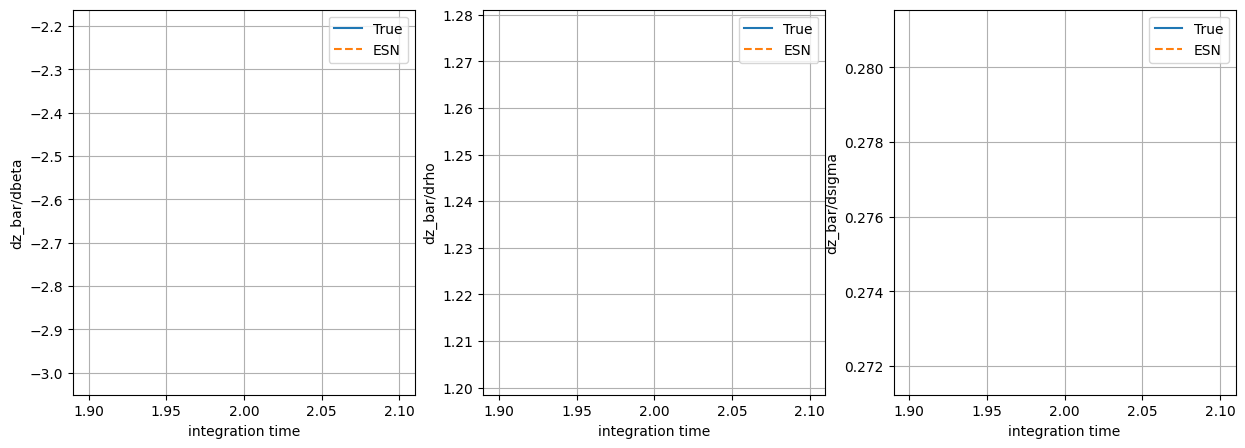

In [12]:
dJdp_true_mean = np.mean(dJdp["true"]["adjoint"], axis = 2)
dJdp_esn_mean = np.mean(dJdp["esn"]["adjoint"], axis = 2)
plt.figure(figsize=(15,5))
for i, param in enumerate(param_vars):
    plt.subplot(1,len(param_vars),i+1)
    vis.plot_lines(loop_time_arr,
                dJdp_true_mean[0,eParam[param],:],
                dJdp_esn_mean[0,eParam[param],:],
                linestyle=["-","--"],
                xlabel="integration time",
                ylabel=f"dz_bar/d{param}",
                )

    plt.legend(["True","ESN"])

beta = 2.667 rho = 28.000 sigma = 10.000


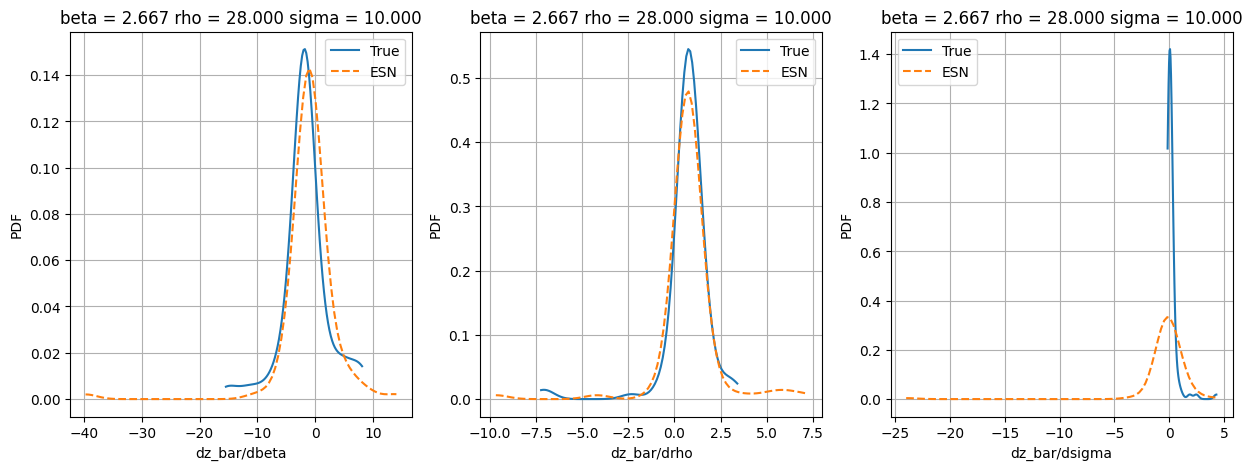

In [27]:
#pdf of the gradients
for p_idx, p in enumerate(p_list):
    plt.figure(figsize=(15,5))
    regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
    print(regime_str)
    for i, param in enumerate(param_vars):
        plt.subplot(1,len(param_vars),i+1)
        vis.plot_statistics(dJdp["true"]["adjoint"][p_idx,eParam[param],:,0],
                    dJdp["esn"]["adjoint"][p_idx,eParam[param],:,0], 
                    linestyle=["-","--"],
                    xlabel=f"dz_bar/d{param}",
                    ylabel="PDF",
                    )
        plt.title(regime_str)
        plt.legend(["True","ESN"])
        # plt.xlim([-2,2])

True beta grad: -1.9166486233512212, ESN beta grad: -2.220890046732855
True rho grad: 1.0054974819961229, ESN rho grad: 1.0669574592475115
True sigma grad: 0.0757424167526074, ESN sigma grad: 0.03452755605686033


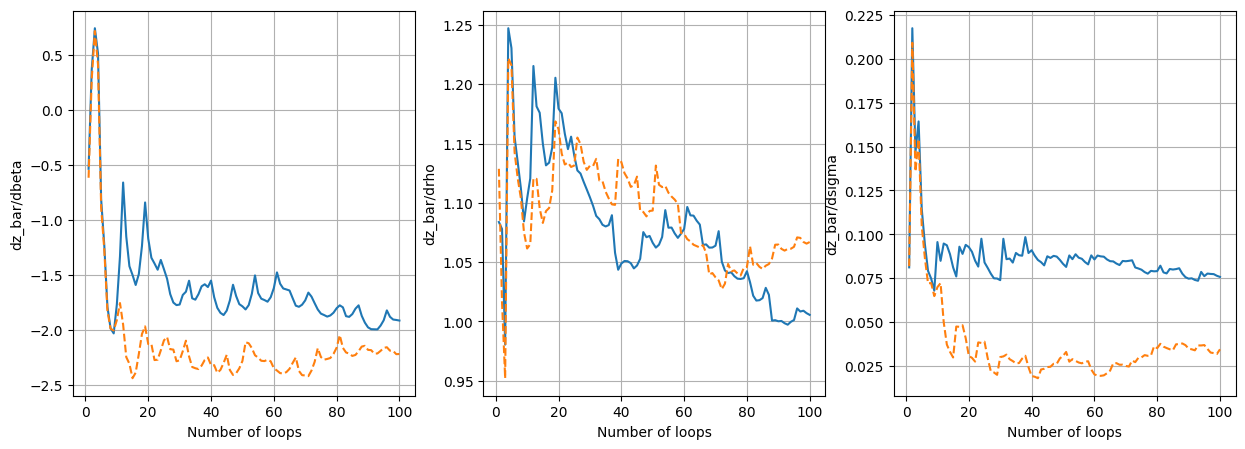

In [20]:
for p_idx, p in enumerate(p_list):
    for loop_time_idx, loop_time in enumerate(loop_time_arr):
        plt.figure(figsize=(15,5))
        for i, param in enumerate(param_vars):
            cum_mean = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp["true"]["adjoint"][p_idx,eParam[param],:,loop_time_idx])
            cum_mean_pred = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp["esn"]["adjoint"][p_idx,eParam[param],:,0])
            plt.subplot(1,len(param_vars),i+1)
            plt.plot(np.arange(1,n_loops+1), cum_mean)
            plt.plot(np.arange(1,n_loops+1), cum_mean_pred, '--')
            plt.xlabel("Number of loops")
            plt.ylabel(f"dz_bar/d{param}")
            print(f'True {param} grad: {cum_mean[-1]}, ESN {param} grad: {cum_mean_pred[-1]}')
            plt.grid()

## aaaa

[0.5]
[0.8]
[1.1]


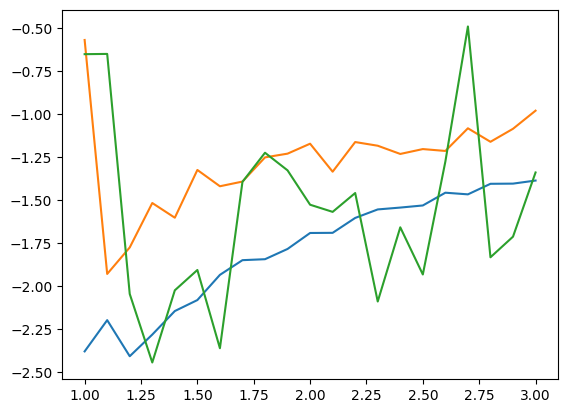

In [9]:
sens_results_list = ["20240214_090024","20240218_152612","20240214_174543"]
for sens_str in sens_results_list:
    sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_str}.pickle"
        )[0]
    sens_results
    dJdp_true_mean = np.mean(sens_results["dJdp"]["true"]["adjoint"], axis=2)
    print(sens_results["loop_times"])
    plt.plot(sens_results["beta_list"],dJdp_true_mean[:,0])

In [28]:
sens_str = "20240214_054527"
sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_str}.pickle"
        )[0]
sens_results["sigma_list"] = sens_results["sigma_list"][:-1]
sens_results["dJdp"]["true"]["adjoint"] = sens_results["dJdp"]["true"]["adjoint"][:-1]
sens_results["dJdp"]["esn"]["adjoint"] = sens_results["dJdp"]["esn"]["adjoint"][:,:-1]
sens_results["J"]["true"] = sens_results["J"]["true"][:-1]
sens_results["J"]["esn"] = sens_results["J"]["esn"][:,:-1]

In [30]:
pp.pickle_file(experiment_path / f"sensitivity_results_{sens_str}.pickle",sens_results)

In [27]:
# sens_results_list = ["20240115_223813","20240115_225852","20240116_003927","20240116_014254","20240116_233616"]
# sens_results_list = ["20240116_014254","20240116_233616"]
# sens_results_list = ["20240122_050248","20240122_072115"]
# sens_results_list = ["20240122_041929","20240122_061243"]
sens_results_list =['20240208_185946','20240208_191537','20240208_200922','20240214_113451']
sens_results = pp.unpickle_file(
        experiment_path / f"sensitivity_results_20240219_122702.pickle"
    )[0]
sens_results

{'dJdp': {'true': {'adjoint': array([[[[-3.16812561e+00],
            [-5.72322241e+00],
            [-1.16205510e+00],
            ...,
            [-6.58341110e+00],
            [-4.43477493e+00],
            [-5.63587710e-01]],
   
           [[ 1.00567404e+00],
            [ 1.05368987e+00],
            [ 1.02129047e+00],
            ...,
            [-1.82397154e-01],
            [ 1.09031562e+00],
            [ 1.10802942e+00]],
   
           [[-8.01989675e-02],
            [ 1.15801159e-01],
            [ 5.14206359e-02],
            ...,
            [ 2.11930466e-01],
            [ 1.69026170e-01],
            [ 4.78401195e-02]]],
   
   
          [[[ 9.81929894e-02],
            [ 3.82141365e-01],
            [-1.70302675e+00],
            ...,
            [-1.49137946e+00],
            [-5.37827018e+00],
            [-4.03284773e+00]],
   
           [[ 1.26243418e+00],
            [ 1.44751692e+00],
            [ 1.13297657e+00],
            ...,
            [ 9.85302926e-

(0.84, 0.9)

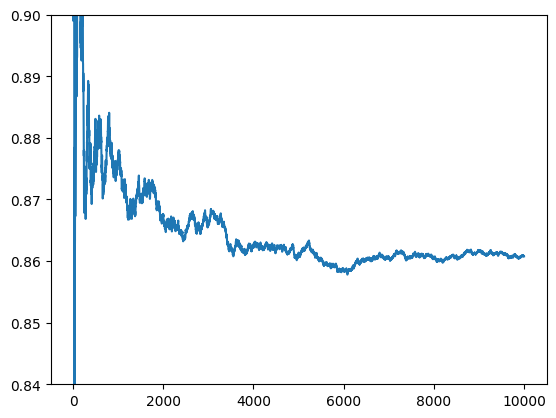

In [5]:
# for i, param in enumerate(param_vars):
n_loops = 10000
dJdp_true = sens_results["dJdp"]["true"]["adjoint"][0,1,:,0]
cum_mean = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp_true)
# plt.subplot(1,len(param_vars),i+1)
plt.plot(np.arange(1,n_loops+1), cum_mean)
plt.ylim([0.84,0.9])

In [130]:
cum_mean[-1]

0.8607813200980605

True: 0.861
ESN: 0.876
True: 0.827
ESN: 0.884
True: 0.772
ESN: 0.807
True: 0.836
ESN: 0.000


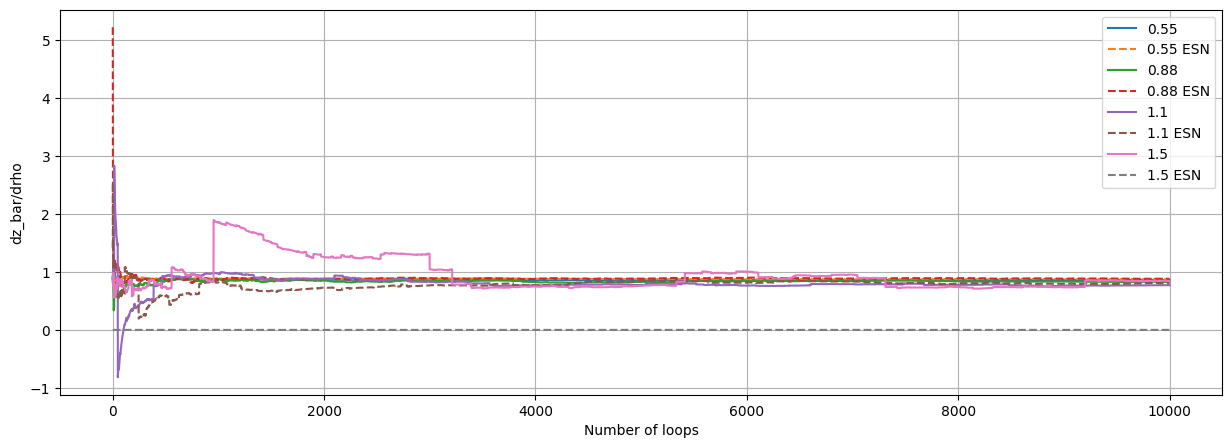

In [33]:
p_list = [[8/3, 28, 10]]
n_loops = 10000
esn_idx = 1
param = "rho"
for p_idx, p in enumerate(p_list):
    legend_str = []
    plt.figure(figsize=(15,5))
    for loop_time_idx in range(len(sens_results_list)):
        sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_results_list[loop_time_idx]}.pickle"
        )[0]
        # for i, param in enumerate(param_vars):
        dJdp_true = sens_results["dJdp"]["true"]["adjoint"][p_idx,eParam[param],:,0]
        cum_mean = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp_true[:n_loops])
        # plt.subplot(1,len(param_vars),i+1)
        plt.plot(np.arange(1,n_loops+1), cum_mean)
        for esn_idx in range(1):
            dJdp_esn = sens_results["dJdp"]["esn"]["adjoint"][esn_idx,p_idx,eParam[param],:,0]
            cum_mean_pred = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp_esn[:n_loops])
            plt.plot(np.arange(1,n_loops+1), cum_mean_pred, '--')
            plt.xlabel("Number of loops")
            plt.ylabel(f"dz_bar/d{param}")
        dJdp_true_mean = np.mean(dJdp_true)
        dJdp_esn_mean = np.mean(dJdp_esn)
        plt.legend(["True","ESN"])
        print(f'True: {dJdp_true_mean:0.3f}')
        print(f'ESN: {dJdp_esn_mean:0.3f}')    
        #     # plt.xlim([0,1000])

        #    
        legend_str.append(f"{sens_results['loop_times'][0]}")
        legend_str.append(f"{sens_results['loop_times'][0]} ESN")
    plt.grid(visible=True)
    plt.legend(legend_str)
    # plt.ylim([-0.25,0.25])
    # plt.xlim([0,50])
plt.show()

beta = 2.667 rho = 28.000 sigma = 10.000
beta = 2.667 rho = 28.000 sigma = 10.000
beta = 2.667 rho = 28.000 sigma = 10.000
beta = 2.667 rho = 28.000 sigma = 10.000


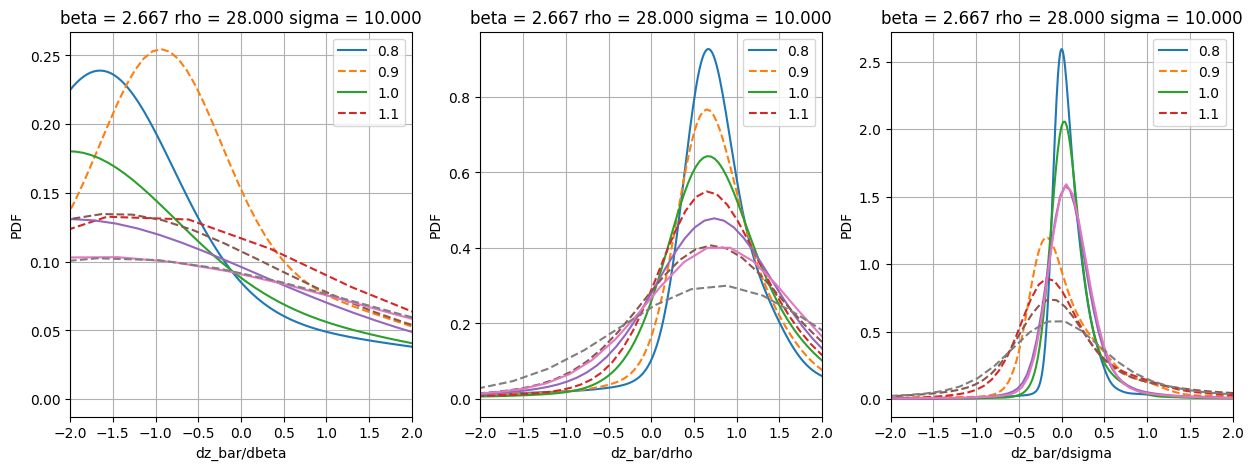

In [99]:
#pdf of the gradients
for p_idx, p in enumerate(p_list):
    plt.figure(figsize=(15,5))
    for loop_time_idx in range(4):
        sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_results_list[loop_time_idx]}.pickle"
        )[0]
        
        regime_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
        print(regime_str)
        for i, param in enumerate(param_vars):
            plt.subplot(1,len(param_vars),i+1)
            vis.plot_statistics(sens_results["dJdp"]["true"]["adjoint"][p_idx,eParam[param],:,0],
                        sens_results["dJdp"]["esn"]["adjoint"][0,p_idx,eParam[param],:,0], 
                        linestyle=["-","--"],
                        xlabel=f"dz_bar/d{param}",
                        ylabel="PDF",
                        n_bins=1000
                        )
            plt.title(regime_str)
            # plt.legend(["True","ESN"])
            plt.legend(["0.8","0.9","1.0","1.1"])
            plt.grid(visible=True)
            # plt.xscale("log")
            # plt.yscale("log")
            # plt.ylim([1e-4,1])
            plt.xlim([-2,2])
plt.show()

In [7]:
sens_results_list = ["20240115_223813","20240115_225852","20240116_003927","20240116_014254"]
sens_results = pp.unpickle_file(
            experiment_path / f"sensitivity_results_{sens_results_list[0]}.pickle"
        )[0]
yy = sens_results["dJdp"]["true"]["adjoint"][0,1,:,0]


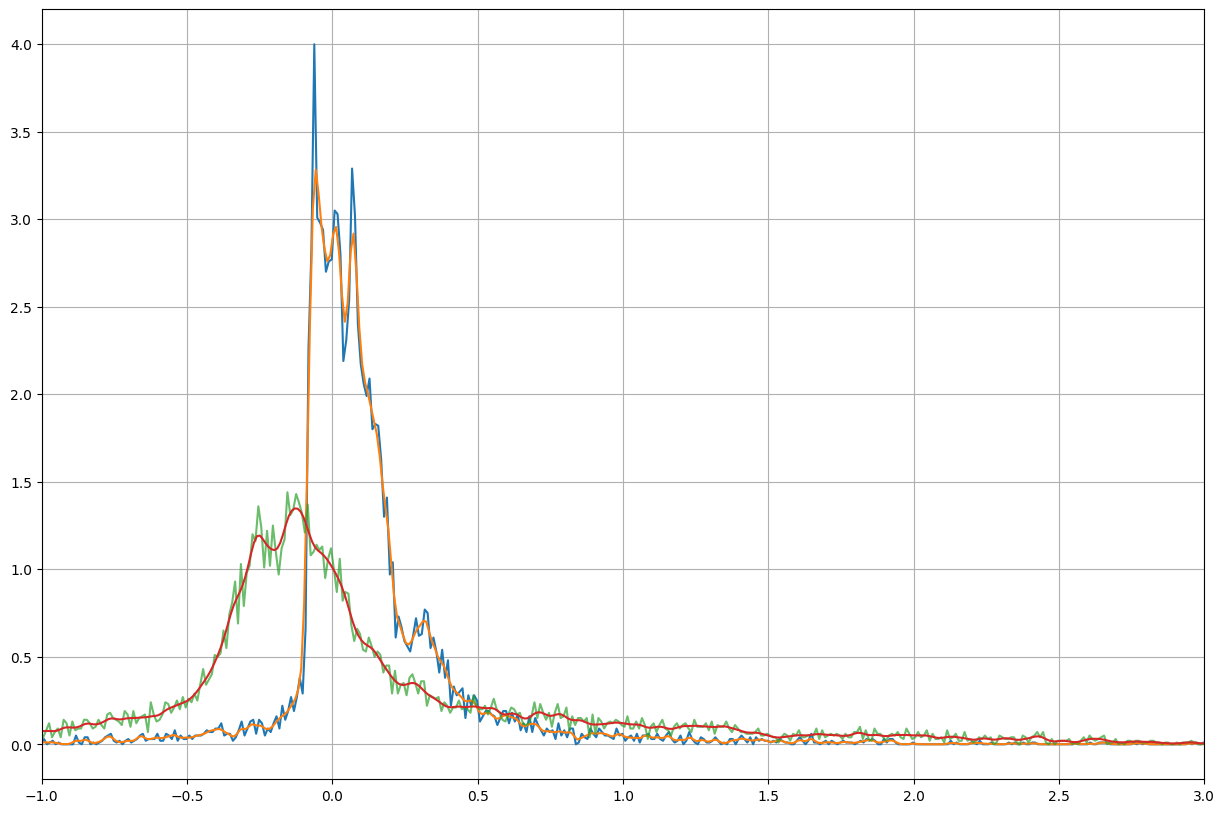

In [92]:
from scipy import signal, stats
n_bins = 1000
binwidth = 0.01
plt.figure(figsize=(15,10))
# for i in range(4):
sens_results = pp.unpickle_file(
        experiment_path / f"sensitivity_results_{sens_results_list[2]}.pickle"
    )[0]
yy = sens_results["dJdp"]["true"]["adjoint"][0,2,:,0]
yy_pred = sens_results["dJdp"]["esn"]["adjoint"][0,0,2,:,0]
density = stats.gaussian_kde(yy, bw_method=0.01)
n, x = np.histogram(yy, bins = np.arange(min(yy), max(yy) + binwidth, binwidth), density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges
plt.plot(x, density(x))

n, x = np.histogram(yy_pred, bins = np.arange(min(yy_pred), max(yy_pred) + binwidth, binwidth), density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
density_pred = stats.gaussian_kde(yy_pred, bw_method=0.01)

plt.plot(bin_centers,n,alpha=0.7) ## using bin_centers rather than edges
plt.plot(x, density_pred(x))

# plt.xscale("log")
# plt.yscale("log")
plt.xlim([-1,3])
A = 0.4897
alpha = 1.865
x2 = np.arange(0.1,100.0,0.1)
yy2 = A * x2 ** -(1+ alpha)
# plt.plot(x2, yy2)
# plt.ylim([1e-2,2])
plt.grid()
plt.show()

In [54]:
loop_times

[10, 100]

## sensitivity to initial conditions

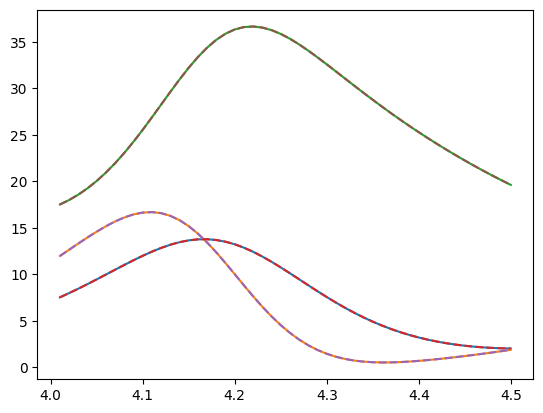

In [51]:
params = {'beta':8/3, 'rho':28, 'sigma':10}
loop_times = [0.5]
sim_time = transient_time+washout_time+loop_times[0]+10
my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                            params,
                                            sim_time,
                                            sim_dt,
                                            # random_seed=3,
                                            # y_init=np.array([-2.4,-3.7,14.98]),
                                            integrator=integrator)

data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=config.model.input_vars,
                    param_vars=config.model.param_vars,
                    loop_times=loop_times,
                    )

# predict on the whole timeseries
N = len(data["loop_0"]["u"])
param0 = np.array([data["loop_0"]["p"][0,:]])
p_washout_auto = np.repeat(param0, [len(DATA["train"]["u_washout"][0])], axis = 0)
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["loop_0"]["u_washout"], 
                                                N_t=N, 
                                                P_washout=data["loop_0"]["p_washout"],  
                                                P=data["loop_0"]["p"])

plt.plot(data["loop_0"]["t"],data["loop_0"]["y"])
plt.plot(data["loop_0"]["t"],y_pred[1:],'--')

In [52]:
def objective_fun(u):
    return u[2]

def dobjective_fun(u):
    dobj = np.zeros(len(u))
    dobj[2] = 1
    return dobj

# dJdx0_finite = my_ESN.finite_difference_sensitivity_x0(x_pred, y_pred, data["loop_0"]["p"], N=N, h=1e-5, method="forward", J_fun=objective_fun)
# dJdx0_direct = my_ESN.direct_sensitivity_x0(x_pred, y_pred, N, dJdy_fun=dobjective_fun, fast_jac=True)
dJdx0_adjoint = my_ESN.adjoint_sensitivity_x0(x_pred, y_pred, N, dJdy_fun=dobjective_fun, fast_jac=True)


# print(dJdx0_finite)
# print(dJdx0_direct)
print(dJdx0_adjoint)

[-4.2659999   2.61408187  4.27926082 ... -8.8832822  -1.09603521
 15.79652774]


In [20]:
%timeit my_ESN.finite_difference_sensitivity_x0(x_pred, y_pred, data["loop_0"]["p"], N=N, h=1e-5, method="forward", J_fun=objective_fun)

2.85 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit my_ESN.direct_sensitivity_x0(x_pred, y_pred, N, dJdy_fun=dobjective_fun, fast_jac=True)

906 ms ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit my_ESN.adjoint_sensitivity_x0(x_pred, y_pred, N, dJdy_fun=dobjective_fun, fast_jac=True)

276 ms ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
def objective_fun(u):
    return u[2]

def dobjective_fun(u):
    dobj = np.zeros(len(u))
    dobj[2] = 1
    return dobj

# dJdu0_finite = my_ESN.finite_difference_sensitivity_u0(x_pred, y_pred, data["loop_0"]["p"], N=N-1, h=1e-5, method="central", J_fun=objective_fun)
# dJdu0_direct = my_ESN.direct_sensitivity_u0(x_pred, y_pred, N-1, dJdy_fun=dobjective_fun, fast_jac=True)
dJdu0_adjoint = my_ESN.adjoint_sensitivity_u0(x_pred, y_pred, N-1, dJdy_fun=dobjective_fun, fast_jac=True)

t = np.arange(N) * network_dt
# dJdu0_finite_true = sens.true_finite_difference_sensitivity_init(
#     my_sys, t, data["loop_0"]["u"], h=1e-5, objective_fun=objective_fun, method='central', integrator="rk4"
# )
# dJdu0_direct_true = sens.true_direct_sensitivity_init(my_sys, t, data["loop_0"]["u"], dobjective_fun=dobjective_fun, integrator="rk4")
dJdu0_adjoint_true = sens.true_adjoint_sensitivity_init(my_sys, t, data["loop_0"]["u"], dobjective_fun=dobjective_fun, integrator="rk4")

# print(dJdu0_finite)
# print(dJdu0_direct)
print(dJdu0_adjoint)
# print(dJdu0_finite_true)
# print(dJdu0_direct_true)
print(dJdu0_adjoint_true)
# if i perturb u0, r0 is still the old one
# does this have an effect?
# it seems that rho = 28 is maybe more difficult

[-0.40426789 -0.55950385  0.31259367]
[-0.39112682 -0.67022367  0.30349211]


In [54]:
print(dJdx0_adjoint)
dJdx0_from_u0 = np.dot(dJdu0_adjoint_true,my_ESN.W_out.T)
print(dJdx0_from_u0)
dJdu0_from_x0 = np.dot(np.linalg.pinv(my_ESN.W_out), dJdx0_adjoint)
print(dJdu0_from_x0)

[-4.2659999   2.61408187  4.27926082 ... -8.8832822  -1.09603521
 15.79652774]
[-7.42013452  0.89220903  4.12719214 ... -9.16116791  5.0609132
 14.51137937]
[-0.4454455  -0.62540299  0.36855041]


In [80]:
params = {'beta':8/3, 'rho':35, 'sigma':10}
loop_times = [0.5]
sim_time = transient_time+washout_time+loop_times[0]+10
n_traj = 10
dJdu0_adjoint_true = np.zeros((n_traj,my_sys.N_dim))
dJdu0_adjoint_esn = np.zeros((n_traj,my_sys.N_dim))
dJdu0_adjoint_esn_from_x0 = np.zeros((n_traj,my_sys.N_dim))
for i in range(n_traj):
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                                params,
                                                sim_time,
                                                sim_dt,
                                                # random_seed=3,
                                                # y_init=np.array([-2.4,-3.7,14.98]),
                                                integrator=integrator)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=config.model.input_vars,
                        param_vars=config.model.param_vars,
                        loop_times=loop_times,
                        )

    # predict on the whole timeseries
    N = len(data["loop_0"]["u"])
    t = np.arange(N) * network_dt

    param0 = np.array([data["loop_0"]["p"][0,:]])
    p_washout_auto = np.repeat(param0, [len(DATA["train"]["u_washout"][0])], axis = 0)
    x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["loop_0"]["u_washout"], 
                                                    N_t=N, 
                                                    P_washout=data["loop_0"]["p_washout"],  
                                                    P=data["loop_0"]["p"])
    
    dJdu0_adjoint_true[i] = sens.true_adjoint_sensitivity_init(my_sys, t, data["loop_0"]["u"], dobjective_fun=dobjective_fun, integrator="rk4")

    dJdu0_adjoint_esn[i] = my_ESN.adjoint_sensitivity_u0(x_pred, y_pred, N-1, dJdy_fun=dobjective_fun, fast_jac=True)

    dJdx0_adjoint = my_ESN.adjoint_sensitivity_x0(x_pred, y_pred, N-1, dJdy_fun=dobjective_fun, fast_jac=True)
    dJdu0_adjoint_esn_from_x0[i] = np.dot(np.linalg.pinv(my_ESN.W_out), dJdx0_adjoint)

In [81]:
np.linalg.norm(dJdu0_adjoint_true-dJdu0_adjoint_esn, axis=1)/np.linalg.norm(dJdu0_adjoint_true, axis=1)

array([0.04444644, 0.19764013, 0.07563167, 0.25650308, 0.08990054,
       0.16059653, 0.09903785, 0.22708021, 0.15255161, 0.14277388])

In [82]:
np.linalg.norm(dJdu0_adjoint_true-dJdu0_adjoint_esn_from_x0, axis=1)/np.linalg.norm(dJdu0_adjoint_true, axis=1)

array([0.15742618, 0.22365132, 0.12809634, 0.35642809, 0.06232608,
       0.08144131, 0.01940286, 0.20919525, 0.08837177, 0.13483905])